<a href="https://colab.research.google.com/github/Emadkadro/MMU_Year2_ML_ClassificationANDRegressionModels_FromScratch/blob/main/1CWK50_regression_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# change current working directory
import os
os.chdir('/content/drive/MyDrive/ML/Assignment/1CWK50-ML/')

In [ ]:
# check we can see the datasets
# datasets that are useful for testing regressors
os.path.isfile('sepal_regression.csv')
os.path.isfile('iris_regression.csv')
os.path.isfile('concrete.csv')

True

### **Import the packages we use**

In [ ]:
# Import the packages we use
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import norm

# KNN Regressor Model
from sklearn.neighbors import KNeighborsRegressor

# Decition Tree Regressor Model
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Random Forest Regressor Model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Linear Regressor Model
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

# Linear Regressor using (Stochastic Gradient Descent) Model
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import time

# Logistic Regression Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


##**MY REGRESSION MODELS CLASSES**

### **My Decision Tree Regressor**

In [ ]:
# Key Changes from Classifier to Regressor:
# 1. Replace the most_common_label function with a function to calculate the mean of the labels.
# 2. Replace entropy-based splitting with variance reduction.
# 3. Modify the predict function to output continuous values instead of class labels.


class Node:
    # Initialise The Node class
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None, class_counts=None):
        self.feature = feature # Index of the feature used for splitting
        self.threshold = threshold  # Threshold value for the split
        self.left = left  # Left child node
        self.right = right # Right child node
        self.value = value # Mean value for regression at leaf nodes

    # Check if Leaf Node means the final prediction for a subset of the tree (the node at the stop condition).
    def is_leaf_node(self):
        return self.value is not None


class MyDecisionTreeRegressor:
    # Decision tree regressor for predicting continuous values
    def __init__(self, max_depth=100, min_samples_split=2, n_features=None, random_state=None):
        self.max_depth = max_depth # Maximum depth of the tree
        self.min_samples_split = min_samples_split # Minimum samples required
        self.n_features = n_features  # Number of features to consider for splitting
        self.random_state = random_state # ability to set the randome state to get the same value for each run
        self.root = None  # Root node of the tree

    # Training the DT Regressor using the train examples/value
    def fit(self, train_examples, train_values):
        # Set n_features to all features if not specified
        self.n_features = train_examples.shape[1] if self.n_features is None else min(train_examples.shape[1], self.n_features)
        # Build the tree starting from the root recursively.
        self.root = self.grow_tree(train_examples, train_values)



    # Building the SubTree using grow_tree function based on the data
    def grow_tree(self, examples, values, depth=0):  # Depth=1 unless we create a new child node
        # Getting the number of samples and features of the training data
        n_samples, n_feats = examples.shape

         # Stopping conditions
        if depth >= self.max_depth or n_samples < self.min_samples_split:
            # Return a leaf node with the mean value of the values
            leaf_value = self.calculate_leaf_value(values)
            return Node(value=leaf_value)

        # Randomly select features to consider for splitting
        feat_idx = np.random.choice(n_feats, self.n_features, replace=False)

        # Find the best feature and threshold for splitting
        best_feature, best_thresh = self.best_split(examples, values, feat_idx)

        # If no valid split is found, return a leaf node
        if best_feature is None or best_thresh is None:
            leaf_value = self.calculate_leaf_value(values)
            return Node(value=leaf_value)

        # Split the data into left and right subsets
        left_indices, right_indices = self.split(examples[:, best_feature], best_thresh)

        # Recursively grow the left and right child nodes
        left = self.grow_tree(examples[left_indices, :], values[left_indices], depth + 1)
        right = self.grow_tree(examples[right_indices, :], values[right_indices], depth + 1)

        # Return a decision node with the best feature and threshold
        return Node(best_feature, best_thresh, left, right)

    # Predict continuous values for each example in the test set.
    def predict(self, test_examples):
        # Traverse the tree for each test example
        return np.array([self.traverse_tree(example, self.root) for example in test_examples])

    # Traverse the tree to predict the value for a single example.
    def traverse_tree(self, example, node):
        # If the node is a leaf, return its value
        if node.is_leaf_node():
            return node.value

        # Decide whether to go left or right based on the threshold
        if example[node.feature] <= node.threshold:
            return self.traverse_tree(example, node.left)
        return self.traverse_tree(example, node.right)

    # Find the best feature and threshold for splitting.
    def best_split(self, examples, values, feat_idx):
        # Randomness for reproducibility
        if self.random_state is not None:
            np.random.seed(self.random_state)

        best_gain = -1  # Initialize best gain to a very low value
        split_idx = None  # Best feature index
        split_threshold = None  # Best threshold value

        for feat in feat_idx:
            feature_values = examples[:, feat]
            thresholds = np.unique(feature_values)  # All unique thresholds for the feature

            # Evaluate each threshold
            for thresh in thresholds:
                gain = self.variance_reduction(values, feature_values, thresh)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat
                    split_threshold = thresh

        return split_idx, split_threshold

    # Calculate the variance reduction achieved by a split.
    def variance_reduction(self, values, feature_values, threshold):
        # Split the data into left and right subsets
        left_indices, right_indices = self.split(feature_values, threshold)

        # If either subset is empty, return zero gain
        if len(left_indices) == 0 or len(right_indices) == 0:
            return 0

        # Variance of the parent node
        var_total = np.var(values)

        # Variance of the left and right child nodes
        var_left = np.var(values[left_indices]) if len(left_indices) > 0 else 0
        var_right = np.var(values[right_indices]) if len(right_indices) > 0 else 0

        # Weighted average of child variances
        weight_left = len(left_indices) / len(values)
        weight_right = len(right_indices) / len(values)
        weighted_variance = weight_left * var_left + weight_right * var_right

        # Variance reduction
        return var_total - weighted_variance

    # Split data into left and right subsets based on a threshold.
    def split(self, feature_values, threshold):
        left_indices = np.argwhere(feature_values <= threshold).flatten()
        right_indices = np.argwhere(feature_values > threshold).flatten()
        return left_indices, right_indices

    # Calculate the value for a leaf node (mean of the values).
    def calculate_leaf_value(self, values):
      if len(values) == 0:
        return 0
      else:
        return np.mean(values)

### **My K-Nearest Neighbors Regressor**

In [ ]:
# Key Changes from Classifier to Regressor:
# 1. Remove all functionality that relies on labels only
# 2. Replace target labels with possible values
# 3. Change predict proba to predict_weights Function.
# 4. Change the Probabilities to predictions



# Create a global function to calculate the distances between nodes
def euclidean_distance(x1, x2): # x reperesent an array
    distance = np.sqrt(np.sum((x1-x2)**2))
    return distance

class MyKnnRegressor:
    def __init__(self, k=1):
        self.k = k

    def fit(self, train_examples, train_values):
      # Store training data and values
        self.train_examples = train_examples
        self.train_values = train_values


    def predict_one(self, test_example):
        # Calculate the distances between the test example and each training example
        distances = [euclidean_distance(test_example, train_example) for train_example in self.train_examples]
        # Get the indices of the k-nearest training examples (sorted by distance)
        k_nearest_indices = np.argsort(distances)[:self.k]
        # Get the value of the k-nearest neighbors
        k_nearest_values = [self.train_values[i] for i in k_nearest_indices]
        # Return the mean value of the k-nearest neighbors
        mean_k_nearest_value = np.mean(k_nearest_values)
        return mean_k_nearest_value

    def predict(self, test_examples):
      # Calculate the prediction for all
        predictions = [self.predict_one(test_example) for test_example in test_examples]
        return predictions

    def predict_weights(self, test_examples):
        predictions = [] # Initialise an empty list to store probability

      # loop over each test example
        for test_example in test_examples:
           # Calculate the Euclidean distance between the test example and each training example
            distances = np.array([euclidean_distance(test_example, train_example) for train_example in self.train_examples])
            # Get the indices of the k-nearest training examples (sorted by distance)
            k_nearest_indices = np.argsort(distances)[:self.k]
            # Get the value of the k-nearest neighbors based on the nearest indices
            k_nearest_values = np.array([self.train_values[i] for i in k_nearest_indices])
            # Get the values of the k-nearest neighbors
            k_nearest_distances = distances[k_nearest_indices]
            weights = 1 / (k_nearest_distances + 1e-5)  # Add a small constant to avoid division by zero
            weighted_average = np.sum(weights * k_nearest_values) / np.sum(weights)
            predictions.append(weighted_average)
        return predictions

### **My Random Forest Regressor**

In [ ]:
# Key Changes from Classifier to Regressor:
# 1. Replace the most_common_label() with a method to calculate the average of trees
# 2. predict_one: will return the average of the predictions made by all trees rather than the most common label.
# 3. Change all labels to values



class MyRandomForestRegressor:
    def __init__(self, n_trees=10, max_depth=None, min_samples_split=2, n_features=None):
        self.n_trees = n_trees  # Number of decision trees in the forest
        self.max_depth = max_depth  # Maximum depth for each tree
        self.min_samples_split = min_samples_split # Minimum samples required to split a node
        self.n_features = n_features  # to get the number of feature when it needed
        self.trees = []  # To store the decision trees in an empty array


    # Create the Forest with different types of trees trained on different training data
    def fit(self, train_examples, train_values):
      self.trees = []  # an araay to hold the tree values
      for _ in range(self.n_trees): #Create trees as the number of n_trees
         # Create a tree using the DT classifier with the parameters initialised above
          tree = MyDecisionTreeRegressor(max_depth=self.max_depth, min_samples_split=self.min_samples_split, n_features=self.n_features)

          # Random selection of samples with replacement using boostrap_samples()
          sampled_examples, sampled_values = self.boostrap_samples(train_examples, train_values)
          # Pass the sampled training data into the fit()
          tree.fit(sampled_examples, sampled_values)
          self.trees.append(tree)  # Add the trained tree to the forest


    def predict_one(self, example):
          predictions = [] # Array to hold predictions
          # Get predictions from all trees for a single example and only preccid if the tree is not empty
          for tree in self.trees:
              if tree is not None: # handle if tree empty
                  tree_prediction = tree.predict([example])[0]
                  if np.isnan(tree_prediction):  # Check if prediction is NaN
                      print("Tree produced NaN prediction.")
                  else:
                      predictions.append(tree_prediction)
          if len(predictions) == 0:
              raise ValueError("All trees produced NaN predictions.")
          # Return the average of each tree predictions
          return np.mean(predictions)

    def predict(self, test_examples):
        # Predict for each example in the test set
        tree_predictions = np.array([self.predict_one(example) for example in test_examples])
        return tree_predictions


    # Helper Function 1
    #-----------------------------------------------------------------------------------------------
    # Random sampling with replacement
    def boostrap_samples(self, train_examples, train_values):
        n_samples = train_examples.shape[0] # First value to get the number of samples
        # Randomly sample data (sampling with replacement)
        indices = np.random.choice(n_samples, n_samples, replace=True)
        # Return the random indices data for training data
        sampled_examples = train_examples[indices]
        sampled_values = train_values[indices]

        if len(sampled_examples) <= 0 or len(sampled_values) <= 0:
            raise ValueError("Bootstrapping resulted in an empty sample.")

        # print Bootstrapped data shape ensuring consistency.
        print("Bootstrapped data shape:", sampled_examples.shape, sampled_values.shape)
        return sampled_examples, sampled_values


### **My Linear Regressor**

In [ ]:
# Define a normal Linear Regressor class
class MyLinearRegressor:
    def __init__(self):
        self.weights = None  # Initialise weights (calculated during training)
        self.bias = None  # Initialise bias (calculated during training)

    def fit(self, train_examples, train_values):
        # Add a column of ones to the training examples for the bias term
        n_samples, n_features = train_examples.shape
        X = np.hstack((np.ones((n_samples, 1)), train_examples))  # Add a bias term (intercept) as the first column
        y = train_values.reshape(-1, 1)  # Ensure target values are in column vector format

        # Calculate weights using the normal equation: w = (X^T * X)^-1 * X^T * y
        X_transpose_X = np.dot(X.T, X)  # Calculate X^T * X
        X_transpose_y = np.dot(X.T, y)  # Calculate X^T * y
        weights_bias = np.linalg.inv(X_transpose_X).dot(X_transpose_y)  # Solve for weights and bias

        # Extract weights and bias from the solution
        self.bias = weights_bias[0, 0]  # First element corresponds to the bias (intercept)
        self.weights = weights_bias[1:, 0]  # Remaining elements are the weights

    def predict(self, test_examples):
        # Calculate predictions using the linear equation: y = wX + b
        return np.dot(test_examples, self.weights) + self.bias

    def calculate_loss(self, test_examples, test_values):
        # Calculate predictions
        predictions = self.predict(test_examples)
        # Calculate Mean Squared Error (MSE)
        mse = mean_squared_error(test_values, predictions)
        return mse

In [ ]:
# Define a normal Linear Regressor class
class LinearRegressor:
    def __init__(self):
        self.weights = None  # initialise weights (calculated during training)
        self.bias = None  # initialise bias (calculated during training)

    def fit(self, train_examples, train_values):
        # Add a column of ones to the training examples for the bias term
        n_samples, n_features = train_examples.shape
        X = np.hstack((np.ones((n_samples, 1)), train_examples))  # Add a bias term (intercept) as the first column
        y = train_values.reshape(-1, 1)  # Ensure target values are in column vector format

        # Calculate weights using the normal equation: w = (X^T * X)^-1 * X^T * y
        X_transpose_X = np.dot(X.T, X)  # Calculate X^T * X
        X_transpose_y = np.dot(X.T, y)  # Calculate X^T * y
        weights_bias = np.linalg.inv(X_transpose_X).dot(X_transpose_y)  # Solve for weights and bias

        # Extract weights and bias from the solution
        self.bias = weights_bias[0, 0]  # First element corresponds to the bias (intercept)
        self.weights = weights_bias[1:, 0]  # Remaining elements are the weights

    def predict(self, test_examples):
        # Calculate predictions using the linear equation: y = wX + b
        return np.dot(test_examples, self.weights) + self.bias

    def calculate_loss(self, test_examples, test_values):
        # Calculate predictions
        predictions = self.predict(test_examples)
        # Calculate Mean Squared Error (MSE)
        mse = mean_squared_error(test_values, predictions)
        return mse

### **My Linear Regressor (Stochastic Gradient Descent)**

In [ ]:

# CLASS PLAN:
# Get the best fitting line using y^ = wX + b
# Initialise: weights, bias

# Fit():
# Create an Estimation Linear Line Using
# Predict using ->  y = wX + b      where (w= weight, X= [x1, x2, xn], b= bias)
# Calculating the MSE
# Using GD to update the new weight and bias
# GD helps to minimise the error by given the direction into the smallest error
# Repeat n times

# Predict()
# Put in the values from data point into the equation.

class MyGDLinearRegressor:
    def __init__(self, learning_rate=None, n_iterations=None):
        self.learning_rate = learning_rate # Will be used to calculate how fast to go to this direction
        self.n_iterations = n_iterations
        self.weights = None #  weights will be set during training
        self.bias = None # bias single scalar value


    def fit(self, train_examples, train_values):
      # Because I have more thean 1 feature I need to return n_features
      n_samples, n_features = train_examples.shape
      self.weights = np.zeros(n_features) # Assign Zeros to all list of weights
      self.bias = 0 # Because its one value

     # Repeate the function n = n_iterations
      for epoch in range(self.n_iterations):
        start_time = time.time() # Start time for measuring epoch duration

        # Create an Estimation Linear Line Using
        # Predict Results using ->  y = wX + b      where (w= weight, X= train[x1, x2, xn], b= bias)
        Linear_pred = np.dot(train_examples, self.weights) + self.bias # using Dot product to get the Linear_pred = weight*[X] + b

        # Calculating GD of the erreor function in tearms of the weight & bias
        dw = (1/n_samples) * np.dot(train_examples.T, (Linear_pred - train_values)) #  gradient descent for weights
        db = (1/n_samples) * np.sum(Linear_pred - train_values) # Gradient for Bias

        # Update Weights and Bias using  -> w = w - a.dw & b = b - a.db
        self.weights -= self.learning_rate * dw # Update the weights
        self.bias -= self.learning_rate * db # Update the bias

        # Calculate average loss (Mean Squared Error)
        loss = np.mean((Linear_pred - train_values) ** 2)

         # Log the training details for the current epoch
        end_time = time.time()  # End time for measuring epoch duration
        print(f"-- Epoch {epoch}")
        print(f"Norm: {np.linalg.norm(self.weights):.2f}, NNZs: {np.count_nonzero(self.weights)}, "
                  f"Bias: {self.bias:.6f}, T: {epoch * n_samples}, Avg. loss: {loss:.6f}")
        print(f"Total training time: {end_time - start_time:.2f} seconds.")


    def predict(self, test_examples):
      # Put in the values from data point into the equation.
       Linear_pred = np.dot(test_examples, self.weights) + self.bias
       return Linear_pred

### **My  Logistic Regression**

In [ ]:
# CLASS PLAN:
# Get the best fitting line for probabilities using y^ = wX + b
# Initialise: weights, bias at zeros

# Fit():
# Create a probabilities line
# Predict using ->  y^ = wX + b      where (w= weight, X= train [x1, x2, xn], b= bias)

# Calculating the min MSE using Gradient Descent to update the parameters
# using (w = w-a.dw) & (b = b-a.db) where (w= weight, b= bias, db=gardient * a=learning_rate)

# GD helps to minimise the error by given the direction into the smallest error
# Repeat n times

# Predict()
# Put in the values from data point into the equation.

#-----------------------------------------------------------------------------------
# Helper Function to transforms a continuous real number into a range of (0, 1).
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
#-------------------------------------------------------------------------- ----------
class MyGDLogisticRegressor:
    def __init__(self, learning_rate=None, n_iterations=None):
        self.learning_rate = learning_rate # Will be used to calculate how fast to go to this direction
        self.n_iterations = n_iterations
        self.weights = None #  weights will be set during training
        self.bias = None # bias will be set during training


    def fit(self, train_examples, train_values):
      # Because I have more thean 1 feature I need to return n_features
      n_samples, n_features = train_examples.shape
      self.weights = np.zeros(n_features) # Assign Zeros to all list of weights
      self.bias = 0 # Because its one value

     # Repeate the function number of n_iterations
      for epoch in range(self.n_iterations):
        # Predict Results using ->  y = wX + b      where (w= weight, X= [x1, x2, xn], b= bias)
        Linear_pred = np.dot(train_examples, self.weights) + self.bias # using Dot product to get the y_pred = weight*[X] + b
        predictions = sigmoid(Linear_pred)


        # Calculating GD of the erreor function in tearms of the weight & bias
        dw = (1/n_samples) * np.dot(train_examples.T, (predictions - train_values)) #  gradient descent for weights
        db = (1/n_samples) * np.sum(predictions - train_values) # Gradient for Bias

        # Update Weghts and Bias -> w = w - a.dw & b = b - a.db
        self.weights = self.weights - self.learning_rate * dw # Update the weights
        self.bias = self.bias - self.learning_rate * db # Update the bias


    def predict(self, test_examples):
        # Linear prediction: y^ = wX + b
        linear_pred = np.dot(test_examples, self.weights) + self.bias
        test_values_predictions = sigmoid(linear_pred)

        # Convert probabilities to binary classes (0 or 1)
        class_pred = [0 if pred <= 0.5 else 1 for pred in test_values_predictions]
        return class_pred

## **iris Regression DataSet:**

In [ ]:
# Load all the observations from file
observations = pd.read_csv('iris_regression.csv')
# Learn about my dataset
print(observations)
print("Number of observations:", observations.shape, "\n")
# Set the name of the target feature
target_feature = 'petal_width'

# Shuffling all the observations
observations_shuffled = observations.sample(frac=1, random_state=99)

# Setting the fraction of observations we will use for testing
testing_fraction = 0.4
split_index = int(observations_shuffled.shape[0] * testing_fraction)

# Splitting into testing observations and training observations ("horizontal split")
observations_test = observations_shuffled.iloc[:split_index]
observations_train = observations_shuffled.iloc[split_index:]

# Splitting into testing examples and testing values ("vertical split")
test_examples = observations_test.drop(columns = target_feature).to_numpy()
test_values = observations_test[target_feature].to_numpy()

# Splitting into training examples and training values ("vertical split")
train_examples = observations_train.drop(columns=target_feature).to_numpy()
train_values = observations_train[target_feature].to_numpy()

     sepal_length  sepal_width  petal_length  petal_width
0             5.1          3.5           1.4          0.2
1             4.9          3.0           1.4          0.2
2             4.7          3.2           1.3          0.2
3             4.6          3.1           1.5          0.2
4             5.0          3.6           1.4          0.2
..            ...          ...           ...          ...
145           6.7          3.0           5.2          2.3
146           6.3          2.5           5.0          1.9
147           6.5          3.0           5.2          2.0
148           6.2          3.4           5.4          2.3
149           5.9          3.0           5.1          1.8

[150 rows x 4 columns]
Number of observations: (150, 4) 



### **KNN Regressor Implementation For iris Dataset**

In [ ]:
# Initialise and fit the regressor
my_knn_regressor = MyKnnRegressor(k=1)

# Fit model using KNN regressor
my_knn_regressor.fit(train_examples, train_values)
# Predict using the KNN regressor
my_knn_predictions = my_knn_regressor.predict(test_examples)

# Output the custom KNN regressor using Mean Squared Error
my_knn_mean_squared_error = mean_squared_error(test_values, my_knn_predictions)
print("My KNN Regressor Mean Squared Error:", my_knn_mean_squared_error)



# scikit-learn implementation
# Fit and output with scikit-learn's KNeighborsRegressor
sklearn_knn = KNeighborsRegressor(n_neighbors=1)

# Fit & Predict using sklearn's KNN regressor
sklearn_knn.fit(train_examples, train_values)
sklearn_predictions = sklearn_knn.predict(test_examples)

# Output sklearn's KNN regressor using Mean Squared Error
sklearn_mse = mean_squared_error(test_values, sklearn_predictions)
print("Scikit-learn KNN Regressor Mean Squared Error:", sklearn_mse)

My KNN Regressor Mean Squared Error: 0.060666666666666653
Scikit-learn KNN Regressor Mean Squared Error: 0.06049999999999999


#### **EVALUATION: KNN Regressor Implementation For iris Dataset**

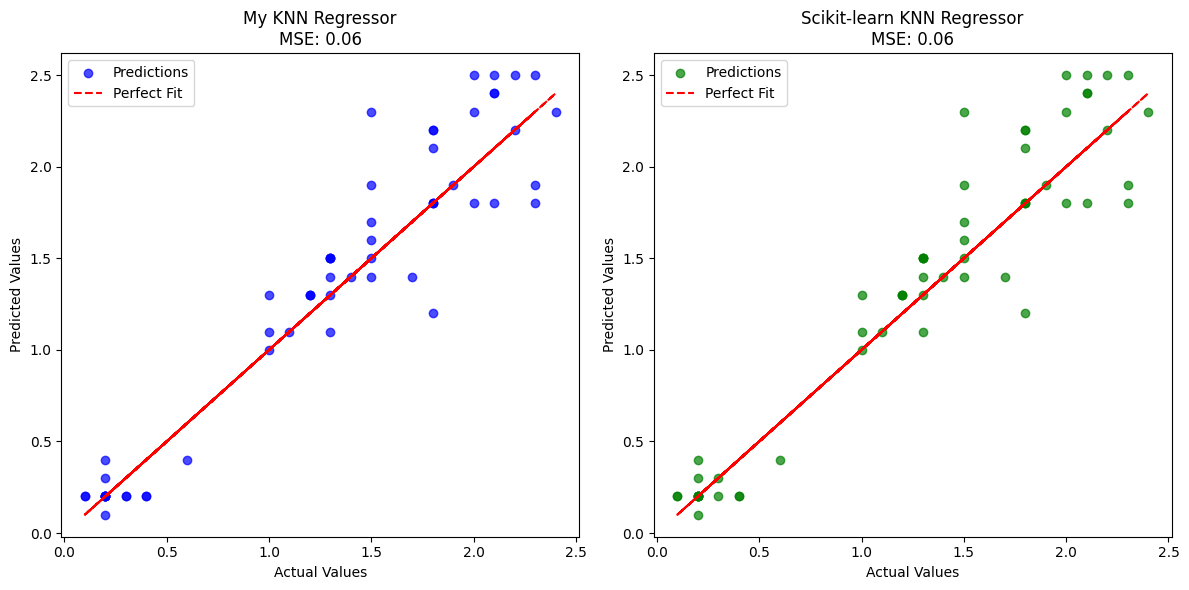

In [ ]:
# Plotting both models for comparison
plt.figure(figsize=(12, 6))  # Set figure size

# Subplot for the My KNN regressor
plt.subplot(1, 2, 1)  # Create the first subplot in a 1x2 grid
plt.scatter(test_values, my_knn_predictions, alpha=0.7, label="Predictions", color="blue")  # Plot predictions using label="Predictions" as it matlap built
plt.plot(test_values, test_values, color="red", linestyle="--", label="Perfect Fit")  # Add diagonal reference line
plt.title("My KNN Regressor\nMSE: {:.2f}".format(my_knn_mean_squared_error)) # Add title
plt.xlabel("Actual Values")  # value for the x-axis
plt.ylabel("Predicted Values")  # value for the y-axis
plt.legend()  # Add legend

# Subplot for the scikit-learn KNN regressor
plt.subplot(1, 2, 2)  # Create the second subplot in a 1x2 grid
plt.scatter(test_values, sklearn_predictions, alpha=0.7, label="Predictions", color="green")  # Plot predictions
plt.plot(test_values, test_values, color="red", linestyle="--", label="Perfect Fit")  # Add diagonal reference line
plt.title("Scikit-learn KNN Regressor\nMSE: {:.2f}".format(sklearn_mse))  # Add title
plt.xlabel("Actual Values")  # value for the x-axis
plt.ylabel("Predicted Values")  # value for the y-axis
plt.legend()  # Add legend

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()  # Display the plot


### **Decision Tree Regressor Implementation For iris Dataset**

In [ ]:
# Create a "Decision Tree" Regressor
my_dt_regressor = MyDecisionTreeRegressor(max_depth=5, random_state=99)

# Call the model's fitting algorithm, passing in our training examples and training values
my_dt_regressor.fit(train_examples, train_values)
# Use the trained model to generate predictions for our testing examples
my_dt_predictions = my_dt_regressor.predict(test_examples)

# Evaluate My Decision Tree Regressor
my_dt_mean_squared_error = mean_squared_error(test_values, my_dt_predictions)



# scikit-learn implementation
# Fitting and predicting using the sklearn
sklearn_dt = DecisionTreeRegressor(max_depth=5, random_state=99)
sklearn_dt.fit(train_examples, train_values)
dt_sklearn_predictions = sklearn_dt.predict(test_examples)

# Evaluate sklearn Decision Tree Regressor
dt_sklearn_mse = mean_squared_error(test_values, dt_sklearn_predictions)

#### **EVALUATION: Decision Tree Regressor Implementation For iris Dataset**

My Decision Tree Regressor Mean Squared Error: 0.05009962277814908
My  Decision Tree Regressor Mean Absolute Error: 0.1652074314574314

 Scikit-learn Decision Tree Regressor Mean Squared Error: 0.050480409815186124
 Scikit-learn  Decision Tree Regressor Mean Absolute Error: 0.16673520923520918

Difference in Mean Squared Error: 0.0003807870370370406
Difference in Mean Squared Error: 0.0015277777777777946


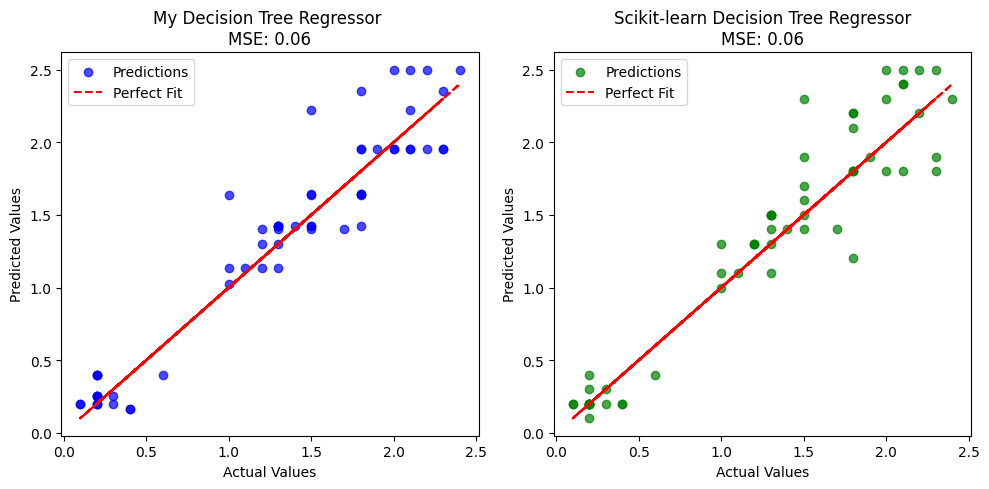

In [ ]:
# Evaluate My Decision Tree Regressor
my_dt_mean_squared_error = mean_squared_error(test_values, my_dt_predictions)
my_dt_mean_absolute_error = mean_absolute_error(test_values, my_dt_predictions)
print(f"My Decision Tree Regressor Mean Squared Error: {my_dt_mean_squared_error}")
print(f"My  Decision Tree Regressor Mean Absolute Error: {my_dt_mean_absolute_error}")

# Evaluate sklearn Decision Tree Regressor
sklearn_mean_squared_error = mean_squared_error(test_values, dt_sklearn_predictions)
sklearn_mean_absolute_error = mean_absolute_error(test_values, dt_sklearn_predictions)
print(f"\n Scikit-learn Decision Tree Regressor Mean Squared Error: {sklearn_mean_squared_error}")
print(f" Scikit-learn  Decision Tree Regressor Mean Absolute Error: {sklearn_mean_absolute_error}")

# Compare Results
print("\nDifference in Mean Squared Error:", abs(my_dt_mean_squared_error - sklearn_mean_squared_error))
print("Difference in Mean Squared Error:", abs(my_dt_mean_absolute_error - sklearn_mean_absolute_error))


# Scatter plot for the My DT regressor
plt.figure(figsize=(10, 5))  # Set figure size

# Subplot for the My DT regressor
plt.subplot(1, 2, 1)  # Create the first subplot in a 1x2 grid
plt.scatter(test_values, my_dt_predictions, alpha=0.7, label="Predictions", color="blue")  # Plot predictions
plt.plot(test_values, test_values, color="red", linestyle="--", label="Perfect Fit")  # Add diagonal reference line
plt.title("My Decision Tree Regressor \nMSE: {:.2f}".format(sklearn_mse))  # Add title
plt.xlabel("Actual Values")  # Label for the x-axis
plt.ylabel("Predicted Values")  # Label for the y-axis
plt.legend()  # Add legend

# Subplot for the scikit-learn DT regressor
plt.subplot(1, 2, 2)  # Create the second subplot in a 1x2 grid
plt.scatter(test_values, sklearn_predictions, alpha=0.7, label="Predictions", color="green")  # Plot predictions
plt.plot(test_values, test_values, color="red", linestyle="--", label="Perfect Fit")  # Add diagonal reference line
plt.title("Scikit-learn Decision Tree Regressor\nMSE: {:.2f}".format(sklearn_mse))  # Add title # Add title
plt.xlabel("Actual Values")  # Label for the x-axis
plt.ylabel("Predicted Values")  # Label for the y-axis
plt.legend()  # Add legend

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()  # Display the plot


### **Random Forest Regressor Implementation For iris Dataset**

In [ ]:
# Create a "Random Forest" Regressor
my_rf_regressor = MyRandomForestRegressor(n_trees=10, max_depth=5)

# Call the model's fitting algorithm, passing in our training examples and training values
my_rf_regressor.fit(train_examples, train_values)
# Use the trained model to generate predictions for our testing examples
my_rf_predictions = my_rf_regressor.predict(test_examples)


# scikit-learn implementation
# Initialise and train scikit-learn RandomForestRegressor
sklearn_rf = RandomForestRegressor(n_estimators=10, max_depth=5)

# Fit and make predictions with scikit-learn RandomForestRegressor
sklearn_rf.fit(train_examples, train_values)
sklearn_rf_predictions = sklearn_rf.predict(test_examples)

Bootstrapped data shape: (90, 3) (90,)
Bootstrapped data shape: (90, 3) (90,)
Bootstrapped data shape: (90, 3) (90,)
Bootstrapped data shape: (90, 3) (90,)
Bootstrapped data shape: (90, 3) (90,)
Bootstrapped data shape: (90, 3) (90,)
Bootstrapped data shape: (90, 3) (90,)
Bootstrapped data shape: (90, 3) (90,)
Bootstrapped data shape: (90, 3) (90,)
Bootstrapped data shape: (90, 3) (90,)


#### **EVALUATION: Random Forest Regressor Implementation For iris Dataset**

My Random Forest Regressor Mean Squared Error: 0.0562907735168594
My Random Forest Regressor Mean Absolute Error: 0.16539556077979994

Scikit-learn Random Forest Regressor Mean Squared Error: 0.0386124063844897
Scikit-learn Random Forest Regressor Mean Absolute Error: 0.14315681216931217

Difference in Mean Squared Error: 0.0176783671323697


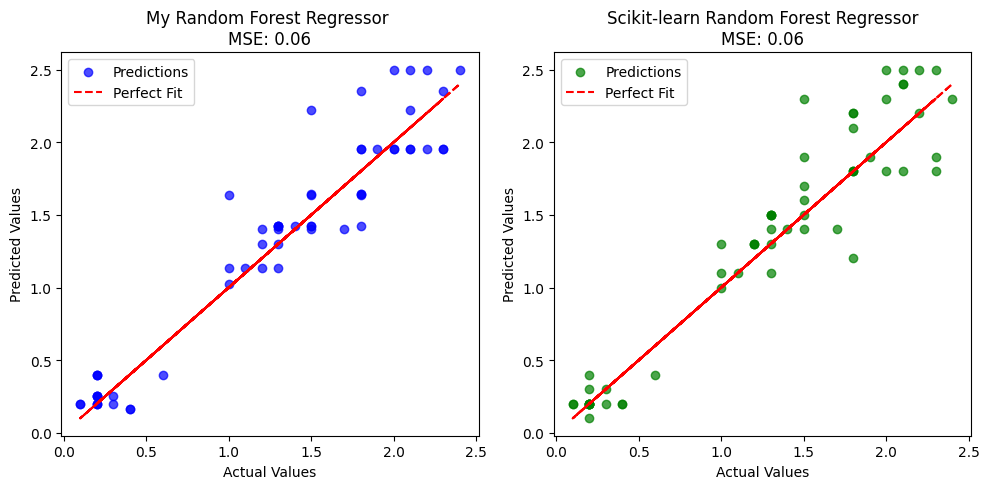

In [ ]:
# Create a mean_absolute_error measurement to compare results
my_rf_mean_absolute_error = mean_absolute_error(test_values, my_rf_predictions)
sklearn_rf_mean_absolute_error = mean_absolute_error(test_values, sklearn_rf_predictions)


# Evaluate MyRandomForestRegressor using Mean Squared Error
my_rf_mean_squared_error = mean_squared_error(test_values, my_rf_predictions)
print("My Random Forest Regressor Mean Squared Error:", my_rf_mean_squared_error)
print("My Random Forest Regressor Mean Absolute Error:", my_rf_mean_absolute_error)


# Evaluate scikit-learn RandomForestRegressor using Mean Squared Error
sklearn_rf_mean_squared_error = mean_squared_error(test_values, sklearn_rf_predictions)
print("\nScikit-learn Random Forest Regressor Mean Squared Error:", sklearn_rf_mean_squared_error)
print("Scikit-learn Random Forest Regressor Mean Absolute Error:", sklearn_rf_mean_absolute_error)

# Compare the results
print("\nDifference in Mean Squared Error:", abs(my_rf_mean_squared_error - sklearn_rf_mean_squared_error))



# Scatter plot for the My Random Forest Regressor r
plt.figure(figsize=(10, 5))  # Set figure size

# Subplot for the My Random Forest Regressor
plt.subplot(1, 2, 1)  # Create the first subplot in a 1x2 grid
plt.scatter(test_values, my_dt_predictions, alpha=0.7, label="Predictions", color="blue")  # Plot predictions
plt.plot(test_values, test_values, color="red", linestyle="--", label="Perfect Fit")  # Add diagonal reference line
plt.title("My Random Forest Regressor \nMSE: {:.2f}".format(sklearn_mse))  # Add title
plt.xlabel("Actual Values")  # Label for the x-axis
plt.ylabel("Predicted Values")  # Label for the y-axis
plt.legend()  # Add legend

# Subplot for the scikit-learn Random Forest Regressor
plt.subplot(1, 2, 2)  # Create the second subplot in a 1x2 grid
plt.scatter(test_values, sklearn_predictions, alpha=0.7, label="Predictions", color="green")  # Plot predictions
plt.plot(test_values, test_values, color="red", linestyle="--", label="Perfect Fit")  # Add diagonal reference line
plt.title("Scikit-learn Random Forest Regressor\nMSE: {:.2f}".format(sklearn_mse))  # Add title # Add title
plt.xlabel("Actual Values")  # Label for the x-axis
plt.ylabel("Predicted Values")  # Label for the y-axis
plt.legend()  # Add legend

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()  # Display the plot


**Tree Results Differences:**

1.   My DecisionTreeRegressor may not exactly replicate scikit-learn's behavior due to splitting rules, handling of ties, etc.).

2.   Randomness in Bootstrapping leads to slight differences results.

### **Linear Regressor Implementation For iris Dataset**

In [ ]:
# Standardise the features to have a mean of 0 and standard deviation of 1
scaler = StandardScaler()
scaler.fit(train_examples)  # Fit the scaler to the training features
train_examples = scaler.transform(train_examples)  # Scale training features
test_examples = scaler.transform(test_examples)  # Scale testing features

# Instantiate and train the custom Linear Regressor
my_linr_regressor = MyLinearRegressor()
my_linr_regressor.fit(train_examples, train_values)  # Train the model on the training dataset

# Generate predictions on the test dataset
my_linr_predictions = my_linr_regressor.predict(test_examples)

# Evaluate the my Linear Regressor
my_mse = mean_squared_error(test_values, my_linr_predictions)  # Mean Squared Error
my_rmse = np.sqrt(my_mse)  # Root Mean Squared Error
print("\nMy Linear Regressor Evaluation:")
print("Mean Squared Error:", my_mse)  # Print Mean Squared Error
print("Root Mean Squared Error:", my_rmse)  # Print Root Mean Squared Error



My Linear Regressor Evaluation:
Mean Squared Error: 0.029464319668199283
Root Mean Squared Error: 0.17165173948492127


#### **EVALUATION: Linear Regressor Implementation For iris Dataset**


My Linear Regressor Mean Squared Error = 0.0295, R² = 0.9443

Scikit-learn LinearRegression Mean Squared Error = 0.0605, R² = 0.8856

My Linear Regressor Model vs scikit-learn LinearRegression Model



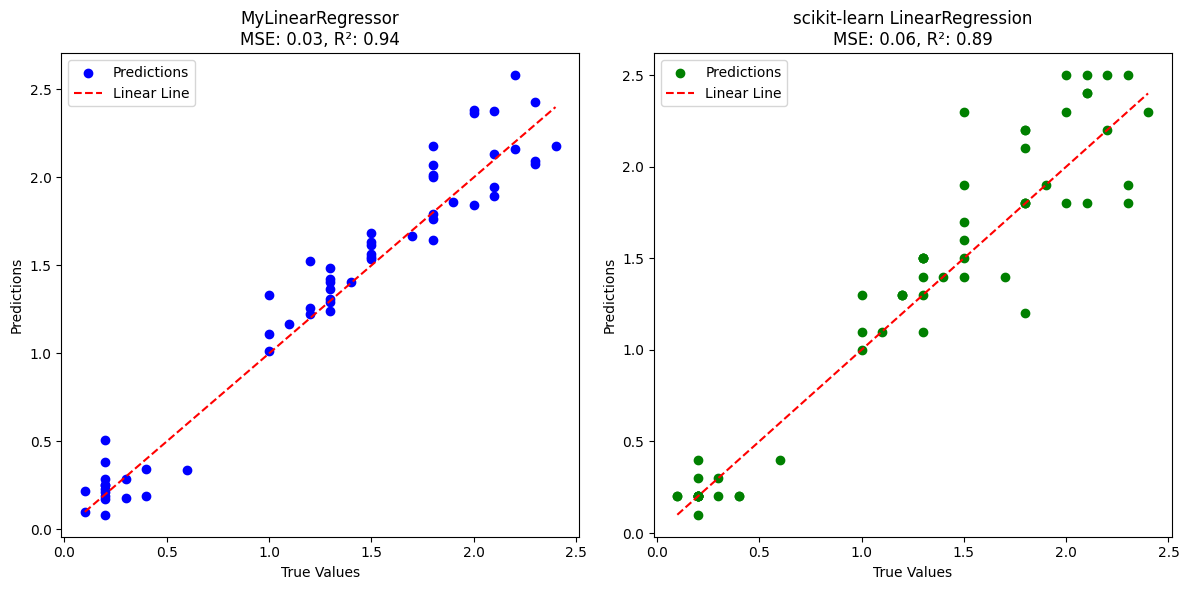

In [ ]:
# My Linear Regressor Model Evaluation
my_linr_mean_squared_error = mean_squared_error(test_values, my_linr_predictions)  # calculate the mse
my_r2 = r2_score(test_values, my_linr_predictions)  # calculate R²
print(f"\nMy Linear Regressor Mean Squared Error = {my_linr_mean_squared_error:.4f}, R² = {my_r2:.4f}")

# scikit-learn LinearRegression Model Evaluation
sklearn_mse = mean_squared_error(test_values, sklearn_predictions)  # calculate the mse
sklearn_r2 = r2_score(test_values, sklearn_predictions)  # calculate R²
print(f"\nScikit-learn LinearRegression Mean Squared Error = {sklearn_mse:.4f}, R² = {sklearn_r2:.4f}")

# Comparison of My Linear Regressor Model vs scikit-learn LinearRegression Model
print("\nMy Linear Regressor Model vs scikit-learn LinearRegression Model\n")
plt.figure(figsize=(12, 6))

# MyLinearRegressor predictions
plt.subplot(1, 2, 1)  # First subplot
plt.scatter(test_values, my_linr_predictions, color='blue', label='Predictions')
plt.plot([min(test_values), max(test_values)], [min(test_values), max(test_values)], 'r--', label='Linear Line')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title(f'MyLinearRegressor\nMSE: {my_linr_mean_squared_error:.2f}, R²: {my_r2:.2f}')
plt.legend()

# scikit-learn LinearRegression predictions
plt.subplot(1, 2, 2)  # Second subplot
plt.scatter(test_values, sklearn_predictions, color='green', label='Predictions')
plt.plot([min(test_values), max(test_values)], [min(test_values), max(test_values)], 'r--', label='Linear Line')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title(f'scikit-learn LinearRegression\nMSE: {sklearn_mse:.2f}, R²: {sklearn_r2:.2f}')
plt.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


 My Linear Regressor Mean Squared Error = 0.0295, R² = 0.9443

 scikit-learn LinearRegression Mean Squared Error = 0.0605, R² = 0.8856

 My Linear Regressor Model vs scikit-learn LinearRegression Model 



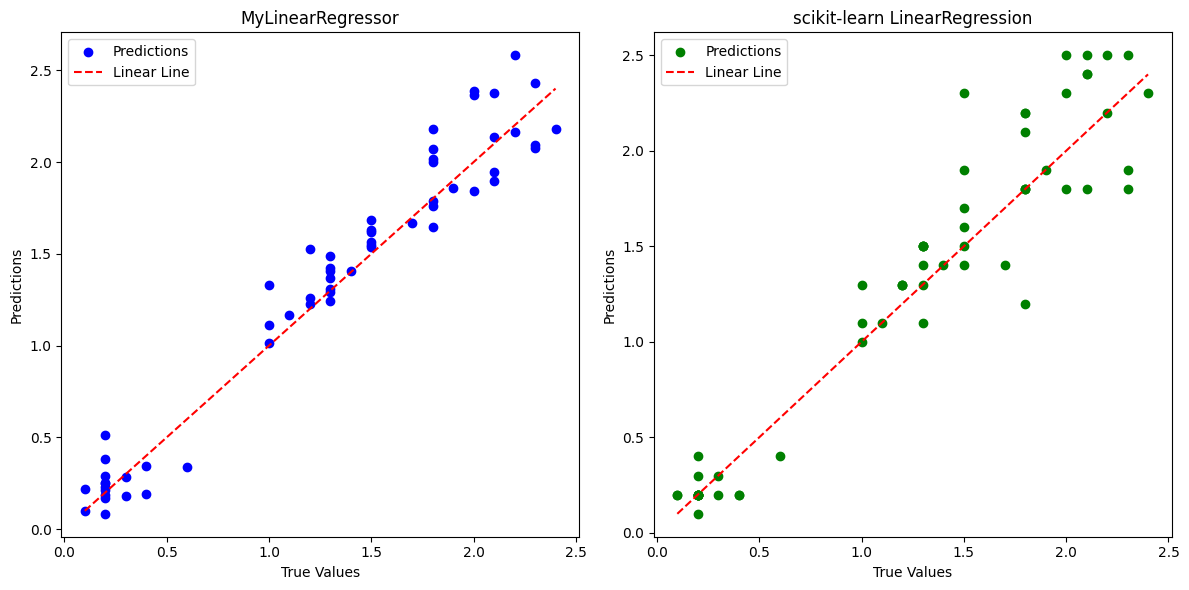

In [ ]:
# My Linear Regressor Model Evaluation
my_linr_mean_squared_error = mean_squared_error(test_values, my_linr_predictions) # calculate the mse
my_r2 = r2_score(test_values, my_linr_predictions) # calculate R²
print(f"\n My Linear Regressor Mean Squared Error = {my_linr_mean_squared_error:.4f}, R² = {my_r2:.4f}")

# scikit-learn LinearRegression Model Evaluation
sklearn_mse = mean_squared_error(test_values, sklearn_predictions)
sklearn_r2 = r2_score(test_values, sklearn_predictions)
print(f"\n scikit-learn LinearRegression Mean Squared Error = {sklearn_mse:.4f}, R² = {sklearn_r2:.4f}")



print("\n My Linear Regressor Model vs scikit-learn LinearRegression Model \n")
plt.figure(figsize=(12, 6))

# MyLinearRegressor predictions
plt.subplot(1, 2, 1)
plt.scatter(test_values, my_linr_predictions, color='blue', label='Predictions')
plt.plot([min(test_values), max(test_values)], [min(test_values), max(test_values)], 'r--', label='Linear Line')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('MyLinearRegressor')
plt.legend()

# scikit-learn LinearRegression predictions
plt.subplot(1, 2, 2)
plt.scatter(test_values, sklearn_predictions, color='green', label='Predictions')
plt.plot([min(test_values), max(test_values)], [min(test_values), max(test_values)], 'r--', label='Linear Line')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('scikit-learn LinearRegression')
plt.legend()

plt.tight_layout()
plt.show()

My MyLinearRegressor performs better because it directly calculates the weights using the normal equation, without regularisation. This approach works well for smaller datasets like Iris. Scikit-learn's model may use regularisation and optimisation, which might not be as well-suited for this particular dataset.

### **Linear Regressor (Stochastic Gradient Descent)**

In [ ]:
print("\n The scikit-learn SGD Regressor Implementation\n")
# Create a linear regression model object (using gradient descent):
my_logr_regressor = SGDRegressor(verbose=1, n_iter_no_change=15)
# Fit the model to our training data
my_logr_regressor.fit(train_examples, train_values)
# Use the model to generate predictions for our testing examples
my_logr_predictions = my_logr_regressor.predict(test_examples)

# Find the mean squared error (MSE) between the model's predictions and the testing values
mse = ((my_logr_predictions - test_values) ** 2).mean()
# Display the MSE as a single quantitative measure of overall performance
print("Mean square error (MSE):", mse)
# Let's also see the square root of the MSE, which is easier for us to interpret
print("Root MSE: ", np.sqrt(mse))


 The scikit-learn SGD Regressor Implementation

-- Epoch 1
Norm: 0.28, NNZs: 3, Bias: 0.376651, T: 90, Avg. loss: 0.604539
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.37, NNZs: 3, Bias: 0.559543, T: 180, Avg. loss: 0.311945
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.42, NNZs: 3, Bias: 0.684081, T: 270, Avg. loss: 0.197467
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.45, NNZs: 3, Bias: 0.775543, T: 360, Avg. loss: 0.137788
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 0.47, NNZs: 3, Bias: 0.845573, T: 450, Avg. loss: 0.102973
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 0.49, NNZs: 3, Bias: 0.900153, T: 540, Avg. loss: 0.081470
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 0.50, NNZs: 3, Bias: 0.943143, T: 630, Avg. loss: 0.067642
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 0.50, NNZs: 3, Bias: 0.978142, T: 720, Avg. loss: 0.058390
Total training time: 0.00 seconds.
-- Epoch 9
Norm: 0.51, NNZs: 3, Bias: 1.006477, T: 810, Avg. los

#### **EVALUATION: Linear Regressor (Stochastic Gradient Descent)**

Compare the implementation to scikit-learn's implementation

In [ ]:
print("\n The scikit-learn SGD Regressor Implementation\n")
# Create a linear regression model object (using gradient descent):
my_logr_regressor = SGDRegressor(verbose=1, n_iter_no_change=15)
# Fit the model to our training data
my_logr_regressor.fit(train_examples, train_values)
# Use the model to generate predictions for our testing examples
my_logr_predictions = my_logr_regressor.predict(test_examples)

# Find the mean squared error (MSE) between the model's predictions and the testing values
mse = ((my_logr_predictions - test_values) ** 2).mean()
# Display the MSE as a single quantitative measure of overall performance
print("Mean square error (MSE):", mse)
# Let's also see the square root of the MSE, which is easier for us to interpret
print("Root MSE: ", np.sqrt(mse))


 The scikit-learn SGD Regressor Implementation

-- Epoch 1
Norm: 0.27, NNZs: 3, Bias: 0.372024, T: 90, Avg. loss: 0.612977
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.37, NNZs: 3, Bias: 0.554697, T: 180, Avg. loss: 0.316527
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.42, NNZs: 3, Bias: 0.680340, T: 270, Avg. loss: 0.199785
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.45, NNZs: 3, Bias: 0.772521, T: 360, Avg. loss: 0.139156
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 0.47, NNZs: 3, Bias: 0.842900, T: 450, Avg. loss: 0.104090
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 0.49, NNZs: 3, Bias: 0.898015, T: 540, Avg. loss: 0.082178
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 0.50, NNZs: 3, Bias: 0.941643, T: 630, Avg. loss: 0.068118
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 0.50, NNZs: 3, Bias: 0.976673, T: 720, Avg. loss: 0.058750
Total training time: 0.00 seconds.
-- Epoch 9
Norm: 0.51, NNZs: 3, Bias: 1.005348, T: 810, Avg. los

### **Logistic Regression Implementation For iris Dataset**

In [ ]:
# Calculate the mean of the training values to use as a threshold for binary use
threshold = train_values.mean()
# Convert train_values to binary: 1 if value > threshold, otherwise 0
train_values = (train_values > threshold).astype(int)
# Convert test_values to binary using the same threshold
test_values = (test_values > threshold).astype(int)


# Initialise the scaler to standardize features
scaler = StandardScaler()
# Fit the scaler to train_examples (calculate mean and std) and transform the data
train_examples = scaler.fit_transform(train_examples)
# Transform the test_examples using the same mean and std from train_examples
test_examples = scaler.transform(test_examples)


# my logistic regression model
# Set the learning rate to 0.01 and the number of iterations to 500
my_logr_regressor = MyGDLogisticRegressor(learning_rate=0.01, n_iterations=500)
# Train the logistic regression model using the standardized training data and binary labels
my_logr_regressor.fit(train_examples, train_values)
# Generate predictions
my_logr_predictions = my_logr_regressor.predict(test_examples)



# scikit-learn's Logistic Regression
sklearn_logr = LogisticRegression(max_iter=500)  # Ensure high enough iterations
sklearn_logr.fit(train_examples, train_values)
# Generate predictions
sklearn_predictions = sklearn_logr.predict(test_examples)

#### **EVALUATION: Logistic Regressor Implementation For iris Dataset**

In [ ]:
# Compare accuracy
my_accuracy = np.sum(my_logr_predictions == test_values) / len(test_values)
sklearn_accuracy = accuracy_score(test_values, sklearn_predictions)
print(f"My Model Accuracy: {my_accuracy:.2f}")
print(f"Scikit-Learn Model Accuracy: {sklearn_accuracy:.2f}")

# Compare other metrics
print("\nClassification Report (My Model):")
print(classification_report(test_values, my_logr_predictions))
print("\nClassification Report (Scikit-Learn):")
print(classification_report(test_values, sklearn_predictions))

# Confusion Matrix
print("\nConfusion Matrix (My Model):")
print(confusion_matrix(test_values, my_logr_predictions))
print("\nConfusion Matrix (Scikit-Learn):")
print(confusion_matrix(test_values, sklearn_predictions))


My Model Accuracy: 0.95
Scikit-Learn Model Accuracy: 0.95

Classification Report (My Model):
              precision    recall  f1-score   support

           0       1.00      0.86      0.92        21
           1       0.93      1.00      0.96        39

    accuracy                           0.95        60
   macro avg       0.96      0.93      0.94        60
weighted avg       0.95      0.95      0.95        60


Classification Report (Scikit-Learn):
              precision    recall  f1-score   support

           0       1.00      0.86      0.92        21
           1       0.93      1.00      0.96        39

    accuracy                           0.95        60
   macro avg       0.96      0.93      0.94        60
weighted avg       0.95      0.95      0.95        60


Confusion Matrix (My Model):
[[18  3]
 [ 0 39]]

Confusion Matrix (Scikit-Learn):
[[18  3]
 [ 0 39]]


## **Sepal Regression Dataset**

In [ ]:
# Load all the observations from file
observations = pd.read_csv('sepal_regression.csv')

# Data Info
print(observations)
print("Number of observations:", observations.shape, "\n")
# Set the name of the target feature
target_feature = 'petal_length'

# Shuffle all the observations
observations_shuffled = observations.sample(frac=1, random_state=99)

# Set the fraction of observations we will use for testing
testing_fraction = 0.4
split_index = int(observations_shuffled.shape[0] * testing_fraction)

# Split into testing observations and training observations ("horizontal split")
observations_test = observations_shuffled.iloc[:split_index]
observations_train = observations_shuffled.iloc[split_index:]

# Split into testing examples and testing values ("vertical split")
test_examples = observations_test.drop(columns=target_feature).to_numpy()
test_values = observations_test[target_feature].to_numpy()

# Split into training examples and training values ("vertical split")
train_examples = observations_train.drop(columns=target_feature).to_numpy()
train_values = observations_train[target_feature].to_numpy()

     sepal_length  sepal_width  petal_length
0             5.1          3.5           1.4
1             4.9          3.0           1.4
2             4.7          3.2           1.3
3             4.6          3.1           1.5
4             5.0          3.6           1.4
..            ...          ...           ...
145           6.7          3.0           5.2
146           6.3          2.5           5.0
147           6.5          3.0           5.2
148           6.2          3.4           5.4
149           5.9          3.0           5.1

[150 rows x 3 columns]
Number of observations: (150, 3) 



### **KNN Regressor Implementation For Sepal Regression Dataset:**

In [ ]:
# Initialise and fit the regressor
my_knn_regressor = MyKnnRegressor(k=5)

# Fit model using KNN regressor
my_knn_regressor.fit(train_examples, train_values)
# Predict using the KNN regressor
my_knn_predictions = my_knn_regressor.predict(test_examples)

# Output the custom KNN regressor using Mean Squared Error
my_knn_mean_squared_error = mean_squared_error(test_values, my_knn_predictions)
print("My KNN Regressor Mean Squared Error:", my_knn_mean_squared_error)



# scikit-learn implementation
# Fit and output with scikit-learn's KNeighborsRegressor
sklearn_knn = KNeighborsRegressor(n_neighbors=5)

# Fit & Predict using sklearn's KNN regressor
sklearn_knn.fit(train_examples, train_values)
sklearn_predictions = sklearn_knn.predict(test_examples)

# Output sklearn's KNN regressor using Mean Squared Error
sklearn_mse = mean_squared_error(test_values, sklearn_predictions)
print("Scikit-learn KNN Regressor Mean Squared Error:", sklearn_mse)

My KNN Regressor Mean Squared Error: 0.2918800000000001
Scikit-learn KNN Regressor Mean Squared Error: 0.2840133333333334


#### **EVALUATION: KNN Regressor Implementation For Sepal Regression Dataset**

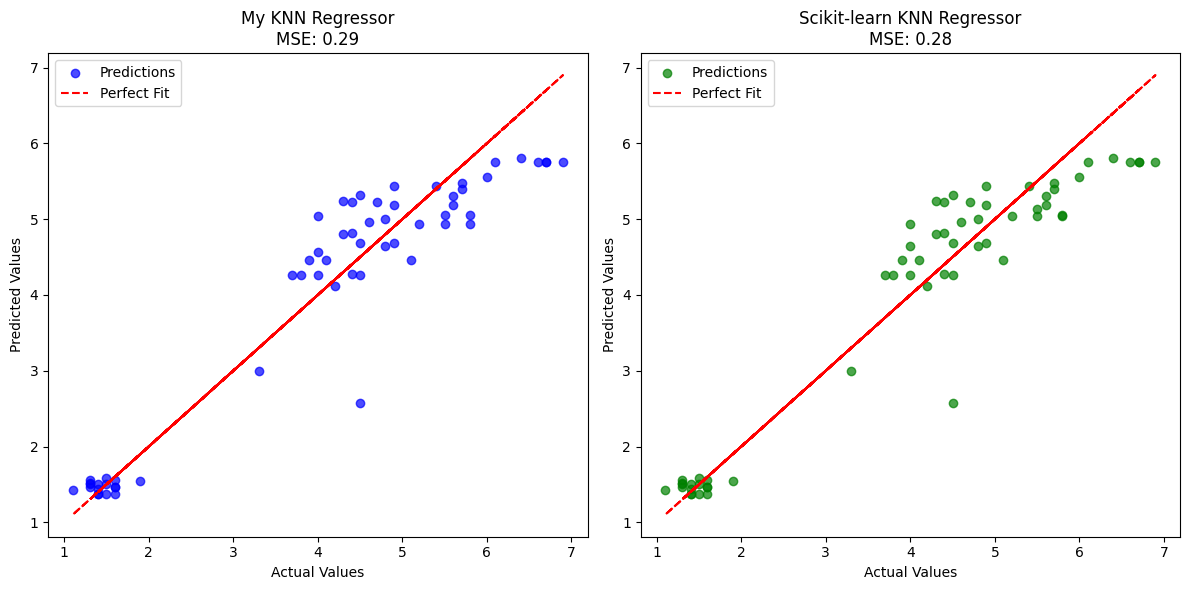

In [ ]:
# Plotting both models for comparison
plt.figure(figsize=(12, 6))  # Set figure size

# Subplot for the My KNN regressor
plt.subplot(1, 2, 1)  # Create the first subplot in a 1x2 grid
plt.scatter(test_values, my_knn_predictions, alpha=0.7, label="Predictions", color="blue")  # Plot predictions
plt.plot(test_values, test_values, color="red", linestyle="--", label="Perfect Fit")  # Add diagonal reference line
plt.title("My KNN Regressor\nMSE: {:.2f}".format(my_knn_mean_squared_error)) # Add title
plt.xlabel("Actual Values")  # Label for the x-axis
plt.ylabel("Predicted Values")  # Label for the y-axis
plt.legend()  # Add legend

# Subplot for the scikit-learn KNN regressor
plt.subplot(1, 2, 2)  # Create the second subplot in a 1x2 grid
plt.scatter(test_values, sklearn_predictions, alpha=0.7, label="Predictions", color="green")  # Plot predictions
plt.plot(test_values, test_values, color="red", linestyle="--", label="Perfect Fit")  # Add diagonal reference line
plt.title("Scikit-learn KNN Regressor\nMSE: {:.2f}".format(sklearn_mse))  # Add title
plt.xlabel("Actual Values")  # Label for the x-axis
plt.ylabel("Predicted Values")  # Label for the y-axis
plt.legend()  # Add legend

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()  # Display the plot


### **Decision Tree Regressor Implementation For Sepal Regression Dataset:**

In [ ]:
# Create a "Decision Tree" Regressor
my_dt_regressor = MyDecisionTreeRegressor(max_depth=5, random_state=99)

# Call the model's fitting algorithm, passing in our training examples and training values
my_dt_regressor.fit(train_examples, train_values)
# Use the trained model to generate predictions for our testing examples
my_dt_predictions = my_dt_regressor.predict(test_examples)

# Evaluate My Decision Tree Regressor
my_dt_mean_squared_error = mean_squared_error(test_values, my_dt_predictions)



# scikit-learn implementation
# Fitting and predicting using the sklearn
sklearn_dt = DecisionTreeRegressor(max_depth=5, random_state=99)
sklearn_dt.fit(train_examples, train_values)
dt_sklearn_predictions = sklearn_dt.predict(test_examples)

# Evaluate sklearn Decision Tree Regressor
dt_sklearn_mse = mean_squared_error(test_values, dt_sklearn_predictions)

#### **EVALUATION: Decision Tree Regressor Implementation For Sepal Regression Dataset**

My Decision Tree Regressor Mean Squared Error: 1.3510805731558007
My  Decision Tree Regressor Mean Absolute Error: 0.5876700336700337

 Scikit-learn Decision Tree Regressor Mean Squared Error: 1.2056176101928378
 Scikit-learn  Decision Tree Regressor Mean Absolute Error: 0.5882255892255892

Difference in MSE: 0.1454629629629629
Difference in MAE: 0.0005555555555555314


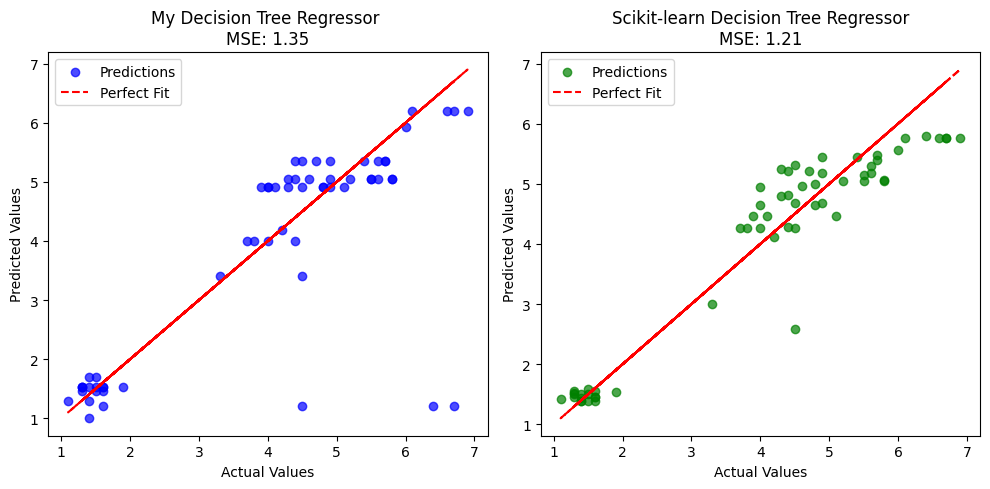

In [ ]:
# Evaluate My Decision Tree Regressor
my_dt_mse = mean_squared_error(test_values, my_dt_predictions)
my_dt_mae = mean_absolute_error(test_values, my_dt_predictions)
print(f"My Decision Tree Regressor Mean Squared Error: {my_dt_mse}")
print(f"My  Decision Tree Regressor Mean Absolute Error: {my_dt_mae}")

# Evaluate sklearn Decision Tree Regressor
sklearn_mse = mean_squared_error(test_values, dt_sklearn_predictions)
sklearn_mae = mean_absolute_error(test_values, dt_sklearn_predictions)
print(f"\n Scikit-learn Decision Tree Regressor Mean Squared Error: {sklearn_mse}")
print(f" Scikit-learn  Decision Tree Regressor Mean Absolute Error: {sklearn_mae}")

# Compare Results
print("\nDifference in MSE:", abs(my_dt_mse - sklearn_mse))
print("Difference in MAE:", abs(my_dt_mae - sklearn_mae))


# Scatter plot for the My DT regressor
plt.figure(figsize=(10, 5))  # Set figure size

# Subplot for the My DT regressor
plt.subplot(1, 2, 1)  # Create the first subplot in a 1x2 grid
plt.scatter(test_values, my_dt_predictions, alpha=0.7, label="Predictions", color="blue")  # Plot predictions
plt.plot(test_values, test_values, color="red", linestyle="--", label="Perfect Fit")  # Add diagonal reference line
plt.title("My Decision Tree Regressor \nMSE: {:.2f}".format(my_dt_mse))  # Add title
plt.xlabel("Actual Values")  # Label for the x-axis
plt.ylabel("Predicted Values")  # Label for the y-axis
plt.legend()  # Add legend

# Subplot for the scikit-learn DT regressor
plt.subplot(1, 2, 2)  # Create the second subplot in a 1x2 grid
plt.scatter(test_values, sklearn_predictions, alpha=0.7, label="Predictions", color="green")  # Plot predictions
plt.plot(test_values, test_values, color="red", linestyle="--", label="Perfect Fit")  # Add diagonal reference line
plt.title("Scikit-learn Decision Tree Regressor\nMSE: {:.2f}".format(sklearn_mse))  # Add title # Add title
plt.xlabel("Actual Values")  # Label for the x-axis
plt.ylabel("Predicted Values")  # Label for the y-axis
plt.legend()  # Add legend

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()  # Display the plot


### **Random Forest Regressor Implementation For Sepal Regression Dataset**

In [ ]:
# Create a "Random Forest" Regressor (Custom Implementation)
my_rf_regressor = MyRandomForestRegressor(n_trees=10, max_depth=5)

# Fit the model with training data
my_rf_regressor.fit(train_examples, train_values)

# Use the trained model to generate predictions for testing data
my_rf_predictions = my_rf_regressor.predict(test_examples)

# scikit-learn implementation of Random Forest Regressor
sklearn_rf = RandomForestRegressor(n_estimators=10, max_depth=5)

# Fit and make predictions with scikit-learn RandomForestRegressor
sklearn_rf.fit(train_examples, train_values)
sklearn_rf_predictions = sklearn_rf.predict(test_examples)

Bootstrapped data shape: (90, 2) (90,)
Bootstrapped data shape: (90, 2) (90,)
Bootstrapped data shape: (90, 2) (90,)
Bootstrapped data shape: (90, 2) (90,)
Bootstrapped data shape: (90, 2) (90,)
Bootstrapped data shape: (90, 2) (90,)
Bootstrapped data shape: (90, 2) (90,)
Bootstrapped data shape: (90, 2) (90,)
Bootstrapped data shape: (90, 2) (90,)
Bootstrapped data shape: (90, 2) (90,)


#### **EVALUATION: Random Forest Regressor Implementation For Sepal Regression Dataset**

My Random Forest Regressor Mean Squared Error: 1.3651419119385655
My Random Forest Regressor Mean Absolute Error: 0.6649330781766127

Scikit-learn Random Forest Regressor Mean Squared Error: 0.8446124704506361
Scikit-learn Random Forest Regressor Mean Absolute Error: 0.5493871519275932

Difference in MSE: 0.5205294414879293
Difference in MAE: 0.11554592624901949


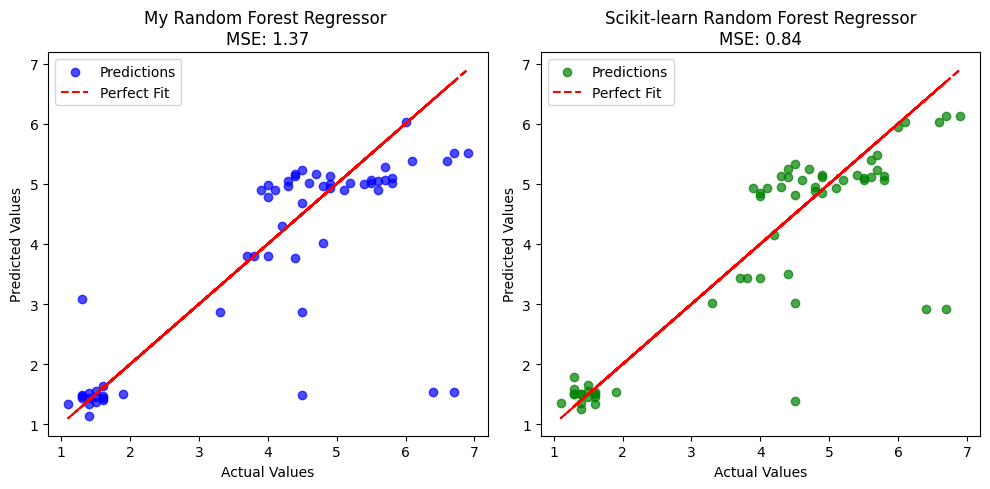

In [ ]:

# Evaluate My Random Forest Regressor
my_rf_mse = mean_squared_error(test_values, my_rf_predictions)
my_rf_mae = mean_absolute_error(test_values, my_rf_predictions)
print(f"My Random Forest Regressor Mean Squared Error: {my_rf_mse}")
print(f"My Random Forest Regressor Mean Absolute Error: {my_rf_mae}")

# Evaluate scikit-learn Random Forest Regressor
sklearn_mse = mean_squared_error(test_values, sklearn_rf_predictions)
sklearn_mae = mean_absolute_error(test_values, sklearn_rf_predictions)
print(f"\nScikit-learn Random Forest Regressor Mean Squared Error: {sklearn_mse}")
print(f"Scikit-learn Random Forest Regressor Mean Absolute Error: {sklearn_mae}")

# Compare Results
print("\nDifference in MSE:", abs(my_rf_mse - sklearn_mse))
print("Difference in MAE:", abs(my_rf_mae - sklearn_mae))

# Scatter plot for My Random Forest Regressor
plt.figure(figsize=(10, 5))  # Set figure size

# Subplot for My Random Forest Regressor
plt.subplot(1, 2, 1)  # Create the first subplot in a 1x2 grid
plt.scatter(test_values, my_rf_predictions, alpha=0.7, label="Predictions", color="blue")  # Plot predictions
plt.plot(test_values, test_values, color="red", linestyle="--", label="Perfect Fit")  # Add diagonal reference line
plt.title(f"My Random Forest Regressor \nMSE: {my_rf_mse:.2f}")  # Add title
plt.xlabel("Actual Values")  # Label for the x-axis
plt.ylabel("Predicted Values")  # Label for the y-axis
plt.legend()  # Add legend

# Subplot for scikit-learn Random Forest Regressor
plt.subplot(1, 2, 2)  # Create the second subplot in a 1x2 grid
plt.scatter(test_values, sklearn_rf_predictions, alpha=0.7, label="Predictions", color="green")  # Plot predictions
plt.plot(test_values, test_values, color="red", linestyle="--", label="Perfect Fit")  # Add diagonal reference line
plt.title(f"Scikit-learn Random Forest Regressor\nMSE: {sklearn_mse:.2f}")  # Add title
plt.xlabel("Actual Values")  # Label for the x-axis
plt.ylabel("Predicted Values")  # Label for the y-axis
plt.legend()  # Add legend

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()  # Display the plot

My Random Forest Regressor has higher Mean Squared Error (MSE) and Mean Absolute Error (MAE) compared to scikit-learn's implementation. This might be due model might not be as effective at fitting the data, possibly due to differences in hyperparameters, training methods, or overfitting. The gap in performance indicates potential areas for optimization in your model.

### **Linear Regressor Implementation For Sepal Regression Dataset**

In [ ]:
# Standardise the features to have a mean of 0 and standard deviation of 1
scaler = StandardScaler()
scaler.fit(train_examples)  # Fit the scaler to the training features
train_examples = scaler.transform(train_examples)  # Scale training features
test_examples = scaler.transform(test_examples)  # Scale testing features

# Instantiate and train the custom Linear Regressor
my_linr_regressor = MyLinearRegressor()
my_linr_regressor.fit(train_examples, train_values)  # Train the model on the training dataset

# Generate predictions on the test dataset
my_linr_predictions = my_linr_regressor.predict(test_examples)

# Evaluate the my Linear Regressor
my_mse = mean_squared_error(test_values, my_linr_predictions)  # Mean Squared Error
my_rmse = np.sqrt(my_mse)  # Root Mean Squared Error
print("\nMy Linear Regressor Evaluation:")
print("Mean Squared Error:", my_mse)  # Print Mean Squared Error
print("Root Mean Squared Error:", my_rmse)  # Print Root Mean Squared Error


# scikit-learn
# Instantiate and train the scikit-learn LinearRegression
sklearn_lin_regressor = LinearRegression()
sklearn_lin_regressor.fit(train_examples, train_values)  # Train the model on the training dataset
# Generate predictions on the test dataset
sklearn_lin_predictions = sklearn_lin_regressor.predict(test_examples)

# Evaluate the scikit-learn Linear Regressor
sklearn_mse = mean_squared_error(test_values, sklearn_lin_predictions)  # Mean Squared Error
sklearn_rmse = np.sqrt(sklearn_mse)  # Root Mean Squared Error
print("\nScikit-learn Linear Regressor Evaluation:")
print("Mean Squared Error:", sklearn_mse)  # Print Mean Squared Error
print("Root Mean Squared Error:", sklearn_rmse)  # Print Root Mean Squared Error


My Linear Regressor Evaluation:
Mean Squared Error: 0.43366252699033
Root Mean Squared Error: 0.6585305816667363

Scikit-learn Linear Regressor Evaluation:
Mean Squared Error: 0.4336625269903297
Root Mean Squared Error: 0.6585305816667361


#### **EVALUATION: Linear Regressor Implementation For Sepal Regression Dataset**


 My Linear Regressor Mean Squared Error = 0.4337, R² = 0.8617

 scikit-learn LinearRegression Mean Squared Error = 0.4337, R² = 0.8617

 My Linear Regressor Model vs scikit-learn LinearRegression Model 



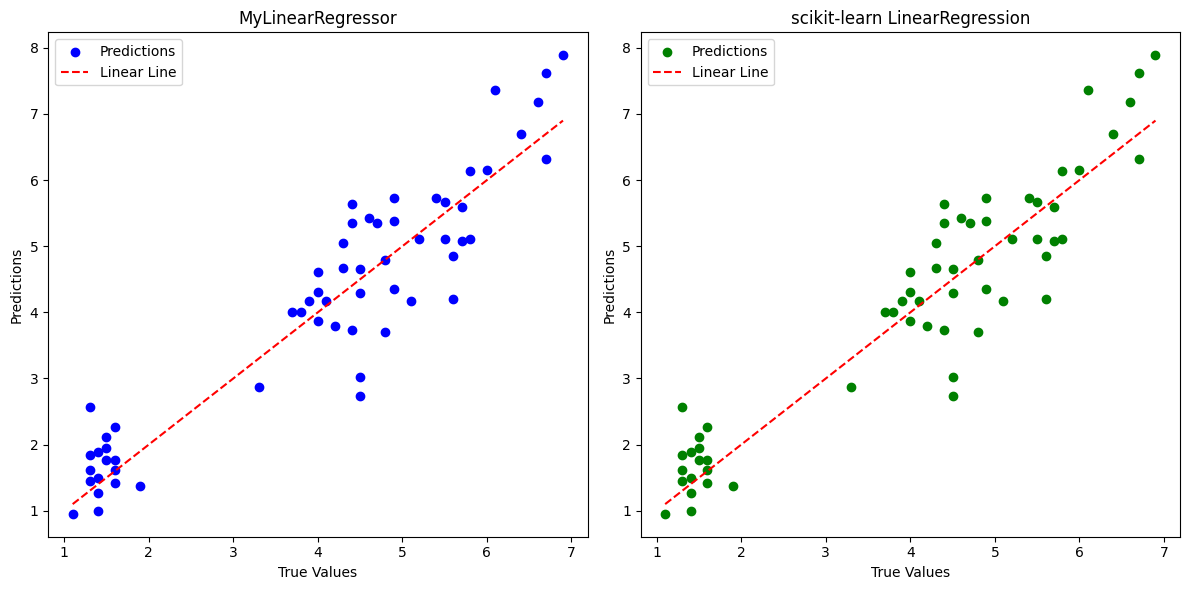

In [ ]:
# Evaluate the MyLinearRegressor Model
my_linr_mean_squared_error = mean_squared_error(test_values, my_linr_predictions)  # Calculate MSE
my_r2 = r2_score(test_values, my_linr_predictions)  # Calculate R²
print(f"\n My Linear Regressor Mean Squared Error = {my_linr_mean_squared_error:.4f}, R² = {my_r2:.4f}")

# Instantiate and train the scikit-learn LinearRegression
sklearn_lin_regressor = LinearRegression()
sklearn_lin_regressor.fit(train_examples, train_values)  # Train the model on the training dataset

# Generate predictions on the test dataset for scikit-learn model
sklearn_predictions = sklearn_lin_regressor.predict(test_examples)

# Evaluate the scikit-learn Linear Regression Model
sklearn_mse = mean_squared_error(test_values, sklearn_predictions)  # Calculate MSE
sklearn_r2 = r2_score(test_values, sklearn_predictions)  # Calculate R²
print(f"\n scikit-learn LinearRegression Mean Squared Error = {sklearn_mse:.4f}, R² = {sklearn_r2:.4f}")

# Compare MyLinearRegressor and scikit-learn LinearRegression Model
print("\n My Linear Regressor Model vs scikit-learn LinearRegression Model \n")
plt.figure(figsize=(12, 6))

# MyLinearRegressor predictions plot
plt.subplot(1, 2, 1)
plt.scatter(test_values, my_linr_predictions, color='blue', label='Predictions')
plt.plot([min(test_values), max(test_values)], [min(test_values), max(test_values)], 'r--', label='Linear Line')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('MyLinearRegressor')
plt.legend()

# scikit-learn LinearRegression predictions plot
plt.subplot(1, 2, 2)
plt.scatter(test_values, sklearn_predictions, color='green', label='Predictions')
plt.plot([min(test_values), max(test_values)], [min(test_values), max(test_values)], 'r--', label='Linear Line')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('scikit-learn LinearRegression')
plt.legend()

plt.tight_layout()
plt.show()


My Linear Regressor has a higher Mean Squared Error (MSE) and lower R² score compared to scikit-learn's implementation. This indicates that while your model performs reasonably well, scikit-learn's model is slightly better at fitting the data.

### **Linear Regressor (Stochastic Gradient Descent)**

In [ ]:
print("\n My SGD Regressor Implementation\n")
# Create a linear regression model object (using gradient descent):
my_logr_regressor = MyGDLinearRegressor(learning_rate=0.168, n_iterations=30)
# Fit the model to our training data
my_logr_regressor.fit(train_examples, train_values)
# Use the model to generate predictions for our testing examples
my_logr_predictions = my_logr_regressor.predict(test_examples)

# Find the mean squared error (MSE) between the model's predictions and the testing values
mse = ((my_logr_predictions - test_values) ** 2).mean()
# Display the MSE as a single quantitative measure of overall performance
print("Mean square error (MSE):", mse)
# Let's also see the square root of the MSE, which is easier for us to interpret
print("Root MSE: ", np.sqrt(mse))


 My SGD Regressor Implementation

-- Epoch 0
Norm: 0.29, NNZs: 2, Bias: 0.605360, T: 0, Avg. loss: 15.993222
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 0.52, NNZs: 2, Bias: 1.109020, T: 90, Avg. loss: 11.096946
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.71, NNZs: 2, Bias: 1.528064, T: 180, Avg. loss: 7.744642
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.86, NNZs: 2, Bias: 1.876709, T: 270, Avg. loss: 5.447535
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.99, NNZs: 2, Bias: 2.166782, T: 360, Avg. loss: 3.872224
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 1.09, NNZs: 2, Bias: 2.408123, T: 450, Avg. loss: 2.791073
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 1.17, NNZs: 2, Bias: 2.608918, T: 540, Avg. loss: 2.048515
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 1.23, NNZs: 2, Bias: 2.775980, T: 630, Avg. loss: 1.538143
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 1.28, NNZs: 2, Bias: 2.914975, T: 720, Avg. loss: 1.187112
To

#### **EVALUATION: Linear Regressor (Stochastic Gradient Descent)**

Compare the implementation to scikit-learn's implementation

In [ ]:

print("\n The scikit-learn SGD Regressor Implementation\n")
# Create a linear regression model object (using gradient descent):
my_logr_regressor = SGDRegressor(verbose=1, n_iter_no_change=15)
# Fit the model to our training data
my_logr_regressor.fit(train_examples, train_values)
# Use the model to generate predictions for our testing examples
my_logr_predictions = my_logr_regressor.predict(test_examples)

# Find the mean squared error (MSE) between the model's predictions and the testing values
mse = ((my_logr_predictions - test_values) ** 2).mean()
# Display the MSE as a single quantitative measure of overall performance
print("Mean square error (MSE):", mse)
# Let's also see the square root of the MSE, which is easier for us to interpret
print("Root MSE: ", np.sqrt(mse))




 The scikit-learn SGD Regressor Implementation

-- Epoch 1
Norm: 0.56, NNZs: 2, Bias: 1.156033, T: 90, Avg. loss: 5.352708
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.81, NNZs: 2, Bias: 1.727557, T: 180, Avg. loss: 2.917629
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.97, NNZs: 2, Bias: 2.117259, T: 270, Avg. loss: 1.837124
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 1.09, NNZs: 2, Bias: 2.403498, T: 360, Avg. loss: 1.240737
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 1.17, NNZs: 2, Bias: 2.622831, T: 450, Avg. loss: 0.883833
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 1.24, NNZs: 2, Bias: 2.793646, T: 540, Avg. loss: 0.660777
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 1.29, NNZs: 2, Bias: 2.928739, T: 630, Avg. loss: 0.517148
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 1.33, NNZs: 2, Bias: 3.037936, T: 720, Avg. loss: 0.422234
Total training time: 0.00 seconds.
-- Epoch 9
Norm: 1.36, NNZs: 2, Bias: 3.126837, T: 810, Avg. los

### **Logistic Regression Implementation For Sepal Regression Dataset**

In [ ]:
# Calculate the mean of the training values to use as a threshold for binary use
threshold = train_values.mean()
# Convert train_values to binary: 1 if value > threshold, otherwise 0
train_values = (train_values > threshold).astype(int)
# Convert test_values to binary using the same threshold
test_values = (test_values > threshold).astype(int)


# Initialise the scaler to standardize features
scaler = StandardScaler()
# Fit the scaler to train_examples (calculate mean and std) and transform the data
train_examples = scaler.fit_transform(train_examples)
# Transform the test_examples using the same mean and std from train_examples
test_examples = scaler.transform(test_examples)


# my logistic regression model
# Set the learning rate to 0.01 and the number of iterations to 500
my_logr_regressor = MyGDLogisticRegressor(learning_rate=0.01, n_iterations=500)
# Train the logistic regression model using the standardized training data and binary labels
my_logr_regressor.fit(train_examples, train_values)
# Generate predictions
my_logr_predictions = my_logr_regressor.predict(test_examples)



# scikit-learn's Logistic Regression
sklearn_logr = LogisticRegression(max_iter=500)  # Ensure high enough iterations
sklearn_logr.fit(train_examples, train_values)
# Generate predictions
sklearn_predictions = sklearn_logr.predict(test_examples)

#### **EVALUATION: Logistic Regressor Implementation For Sepal Regression Dataset**

In [ ]:
# Compare accuracy
my_accuracy = np.sum(my_logr_predictions == test_values) / len(test_values)
sklearn_accuracy = accuracy_score(test_values, sklearn_predictions)
print(f"My Model Accuracy: {my_accuracy:.2f}")
print(f"Scikit-Learn Model Accuracy: {sklearn_accuracy:.2f}")

# Compare other metrics
print("\nClassification Report (My Model):")
print(classification_report(test_values, my_logr_predictions))
print("\nClassification Report (Scikit-Learn):")
print(classification_report(test_values, sklearn_predictions))

# Confusion Matrix
print("\nConfusion Matrix (My Model):")
print(confusion_matrix(test_values, my_logr_predictions))
print("\nConfusion Matrix (Scikit-Learn):")
print(confusion_matrix(test_values, sklearn_predictions))

My Model Accuracy: 0.97
Scikit-Learn Model Accuracy: 0.97

Classification Report (My Model):
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        18
           1       1.00      0.95      0.98        42

    accuracy                           0.97        60
   macro avg       0.95      0.98      0.96        60
weighted avg       0.97      0.97      0.97        60


Classification Report (Scikit-Learn):
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        18
           1       1.00      0.95      0.98        42

    accuracy                           0.97        60
   macro avg       0.95      0.98      0.96        60
weighted avg       0.97      0.97      0.97        60


Confusion Matrix (My Model):
[[18  0]
 [ 2 40]]

Confusion Matrix (Scikit-Learn):
[[18  0]
 [ 2 40]]


## **Concrete Dataset**

In [ ]:
# Load all the observations from file
observations = pd.read_csv('concrete.csv')
# Learn about my dataset
# Data Info
print(observations)
print("Number of observations:", observations.shape, "\n")
# Set the name of the target feature
target_feature = 'strength'

# Shuffling all the observations
observations_shuffled = observations.sample(frac=1, random_state=99)

# Setting the fraction of observations we will use for testing
testing_fraction = 0.4
split_index = int(observations_shuffled.shape[0] * testing_fraction)

# Splitting into testing observations and training observations ("horizontal split")
observations_test = observations_shuffled.iloc[:split_index]
observations_train = observations_shuffled.iloc[split_index:]

# Splitting into testing examples and testing values ("vertical split")
test_examples = observations_test.drop(columns = target_feature).to_numpy()
test_values = observations_test[target_feature].to_numpy()

# Splitting into training examples and training values ("vertical split")
train_examples = observations_train.drop(columns=target_feature).to_numpy()
train_values = observations_train[target_feature].to_numpy()

      cement   slag  ash  water  superplastic  coarseagg  fineagg  age  \
0      108.3  162.4  0.0  203.5           0.0      938.2    849.0    3   
1      122.6  183.9  0.0  203.5           0.0      958.2    800.1    3   
2      102.0  153.0  0.0  192.0           0.0      887.0    942.0    3   
3      153.0  102.0  0.0  192.0           0.0      888.0    943.1    3   
4      141.3  212.0  0.0  203.5           0.0      971.8    748.5    3   
...      ...    ...  ...    ...           ...        ...      ...  ...   
1025   389.9  189.0  0.0  145.9          22.0      944.7    755.8   56   
1026   540.0    0.0  0.0  162.0           2.5     1040.0    676.0   28   
1027   323.7  282.8  0.0  183.8          10.3      942.7    659.9   56   
1028   315.0  137.0  0.0  145.0           5.9     1130.0    745.0   28   
1029   389.9  189.0  0.0  145.9          22.0      944.7    755.8   91   

      strength  
0         2.33  
1         3.32  
2         4.57  
3         4.78  
4         4.83  
...      

### **KNN Regressor Implementation For Concrete Dataset:**

In [ ]:
# Initialise and fit the regressor
my_knn_regressor = MyKnnRegressor(k=5)

# Fit model using KNN regressor
my_knn_regressor.fit(train_examples, train_values)
# Predict using the KNN regressor
my_knn_predictions = my_knn_regressor.predict(test_examples)

# Output the custom KNN regressor using Mean Squared Error
my_knn_mean_squared_error = mean_squared_error(test_values, my_knn_predictions)
print("My KNN Regressor Mean Squared Error:", my_knn_mean_squared_error)



# scikit-learn implementation
# Fit and output with scikit-learn's KNeighborsRegressor
sklearn_knn = KNeighborsRegressor(n_neighbors=5)

# Fit & Predict using sklearn's KNN regressor
sklearn_knn.fit(train_examples, train_values)
sklearn_predictions = sklearn_knn.predict(test_examples)

# Output sklearn's KNN regressor using Mean Squared Error
sklearn_mse = mean_squared_error(test_values, sklearn_predictions)
print("Scikit-learn KNN Regressor Mean Squared Error:", sklearn_mse)

My KNN Regressor Mean Squared Error: 80.27896256310679
Scikit-learn KNN Regressor Mean Squared Error: 80.0668967669903


#### **EVALUATION: KNN Regressor Implementation For Concrete Dataset**

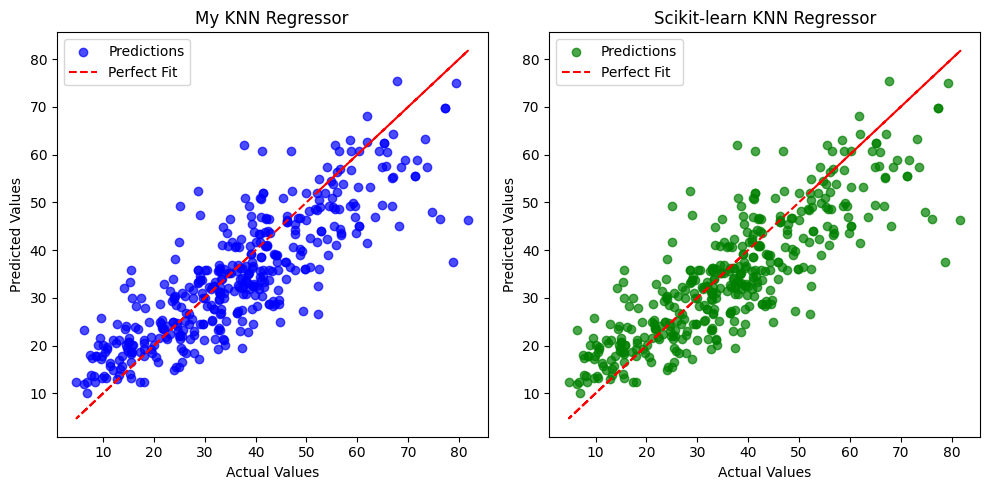

In [ ]:
# Scatter plot for the My KNN regressor
plt.figure(figsize=(10, 5))  # Set figure size

# Subplot for the My KNN regressor
plt.subplot(1, 2, 1)  # Create the first subplot in a 1x2 grid
plt.scatter(test_values, my_knn_predictions, alpha=0.7, label="Predictions", color="blue")  # Plot predictions
plt.plot(test_values, test_values, color="red", linestyle="--", label="Perfect Fit")  # Add diagonal reference line
plt.title("My KNN Regressor")  # Add title
plt.xlabel("Actual Values")  # Label for the x-axis
plt.ylabel("Predicted Values")  # Label for the y-axis
plt.legend()  # Add legend

# Subplot for the scikit-learn KNN regressor
plt.subplot(1, 2, 2)  # Create the second subplot in a 1x2 grid
plt.scatter(test_values, sklearn_predictions, alpha=0.7, label="Predictions", color="green")  # Plot predictions
plt.plot(test_values, test_values, color="red", linestyle="--", label="Perfect Fit")  # Add diagonal reference line
plt.title("Scikit-learn KNN Regressor")  # Add title
plt.xlabel("Actual Values")  # Label for the x-axis
plt.ylabel("Predicted Values")  # Label for the y-axis
plt.legend()  # Add legend

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()  # Display the plot


### **Decision Tree Regressor Implementation For Concrete Dataset:**

In [ ]:
# Create a "Decision Tree" Regressor
my_dt_regressor = MyDecisionTreeRegressor(max_depth=5, random_state=99)

# Call the model's fitting algorithm, passing in our training examples and training values
my_dt_regressor.fit(train_examples, train_values)
# Use the trained model to generate predictions for our testing examples
my_dt_predictions = my_dt_regressor.predict(test_examples)

# Evaluate My Decision Tree Regressor
my_dt_mean_squared_error = mean_squared_error(test_values, my_dt_predictions)



# scikit-learn implementation
# Fitting and predicting using the sklearn
sklearn_dt = DecisionTreeRegressor(max_depth=5, random_state=99)
sklearn_dt.fit(train_examples, train_values)
dt_sklearn_predictions = sklearn_dt.predict(test_examples)

# Evaluate sklearn Decision Tree Regressor
dt_sklearn_mse = mean_squared_error(test_values, dt_sklearn_predictions)

#### **EVALUATION: Decision Tree Regressor Implementation For Concrete Dataset**

My Decision Tree Regressor Mean Squared Error: 71.39185519271071
My  Decision Tree Regressor Mean Absolute Error: 6.409540770955647

 Scikit-learn Decision Tree Regressor Mean Squared Error: 69.99719094791467
 Scikit-learn  Decision Tree Regressor Mean Absolute Error: 6.378086840147143

Difference in MSE: 1.394664244796033
Difference in MAE: 0.031453930808504005


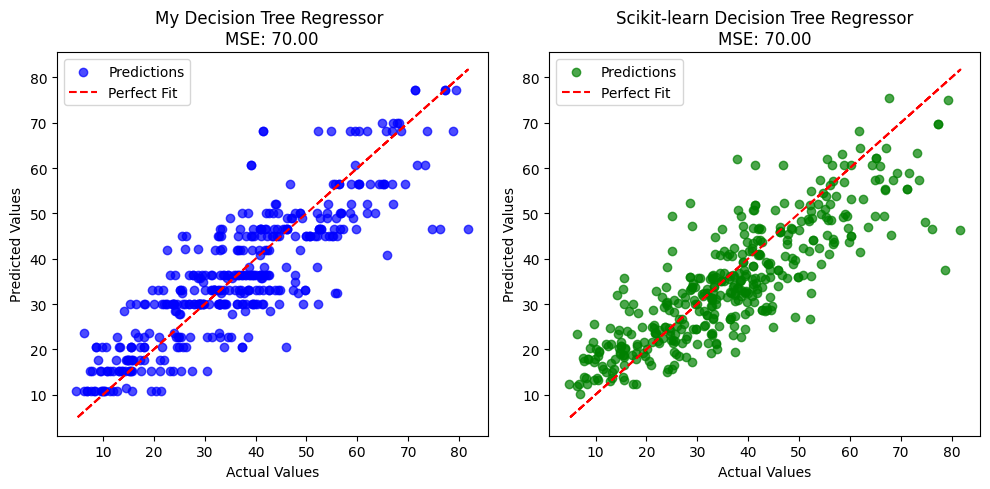

In [ ]:
# Evaluate My Decision Tree Regressor
my_dt_mse = mean_squared_error(test_values, my_dt_predictions)
my_dt_mae = mean_absolute_error(test_values, my_dt_predictions)
print(f"My Decision Tree Regressor Mean Squared Error: {my_dt_mse}")
print(f"My  Decision Tree Regressor Mean Absolute Error: {my_dt_mae}")

# Evaluate sklearn Decision Tree Regressor
sklearn_mse = mean_squared_error(test_values, dt_sklearn_predictions)
sklearn_mae = mean_absolute_error(test_values, dt_sklearn_predictions)
print(f"\n Scikit-learn Decision Tree Regressor Mean Squared Error: {sklearn_mse}")
print(f" Scikit-learn  Decision Tree Regressor Mean Absolute Error: {sklearn_mae}")

# Compare Results
print("\nDifference in MSE:", abs(my_dt_mse - sklearn_mse))
print("Difference in MAE:", abs(my_dt_mae - sklearn_mae))


# Scatter plot for the My DT regressor
plt.figure(figsize=(10, 5))  # Set figure size

# Subplot for the My DT regressor
plt.subplot(1, 2, 1)  # Create the first subplot in a 1x2 grid
plt.scatter(test_values, my_dt_predictions, alpha=0.7, label="Predictions", color="blue")  # Plot predictions
plt.plot(test_values, test_values, color="red", linestyle="--", label="Perfect Fit")  # Add diagonal reference line
plt.title("My Decision Tree Regressor \nMSE: {:.2f}".format(sklearn_mse))  # Add title
plt.xlabel("Actual Values")  # Label for the x-axis
plt.ylabel("Predicted Values")  # Label for the y-axis
plt.legend()  # Add legend

# Subplot for the scikit-learn DT regressor
plt.subplot(1, 2, 2)  # Create the second subplot in a 1x2 grid
plt.scatter(test_values, sklearn_predictions, alpha=0.7, label="Predictions", color="green")  # Plot predictions
plt.plot(test_values, test_values, color="red", linestyle="--", label="Perfect Fit")  # Add diagonal reference line
plt.title("Scikit-learn Decision Tree Regressor\nMSE: {:.2f}".format(sklearn_mse))  # Add title # Add title
plt.xlabel("Actual Values")  # Label for the x-axis
plt.ylabel("Predicted Values")  # Label for the y-axis
plt.legend()  # Add legend

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()  # Display the plot


### **Random Forest Implementation For Concrete Dataset**

In [ ]:
# Create a "Random Forest" Regressor
my_rf_regressor = MyRandomForestRegressor(n_trees=10, max_depth=5)

# Call the model's fitting algorithm, passing in our training examples and training values
my_rf_regressor.fit(train_examples, train_values)
# Use the trained model to generate predictions for our testing examples
my_rf_predictions = my_rf_regressor.predict(test_examples)


# scikit-learn implementation
# Initialise and train scikit-learn RandomForestRegressor
sklearn_rf = RandomForestRegressor(n_estimators=10, max_depth=5)

# Fit and make predictions with scikit-learn RandomForestRegressor
sklearn_rf.fit(train_examples, train_values)
sklearn_rf_predictions = sklearn_rf.predict(test_examples)

Bootstrapped data shape: (618, 8) (618,)
Bootstrapped data shape: (618, 8) (618,)
Bootstrapped data shape: (618, 8) (618,)
Bootstrapped data shape: (618, 8) (618,)
Bootstrapped data shape: (618, 8) (618,)
Bootstrapped data shape: (618, 8) (618,)
Bootstrapped data shape: (618, 8) (618,)
Bootstrapped data shape: (618, 8) (618,)
Bootstrapped data shape: (618, 8) (618,)
Bootstrapped data shape: (618, 8) (618,)


#### **EVALUATION: Random Forest Implementation For Concrete Dataset**

My Random Forest Regressor Mean Squared Error: 52.55316786569422
My Random Forest Regressor Mean Absolute Error: 5.593627673983816

Scikit-learn Random Forest Regressor Mean Squared Error: 48.09271000421571
Scikit-learn Random Forest Regressor Mean Absolute Error: 5.400704442440118

Difference in Mean Squared Error: 4.46045786147851


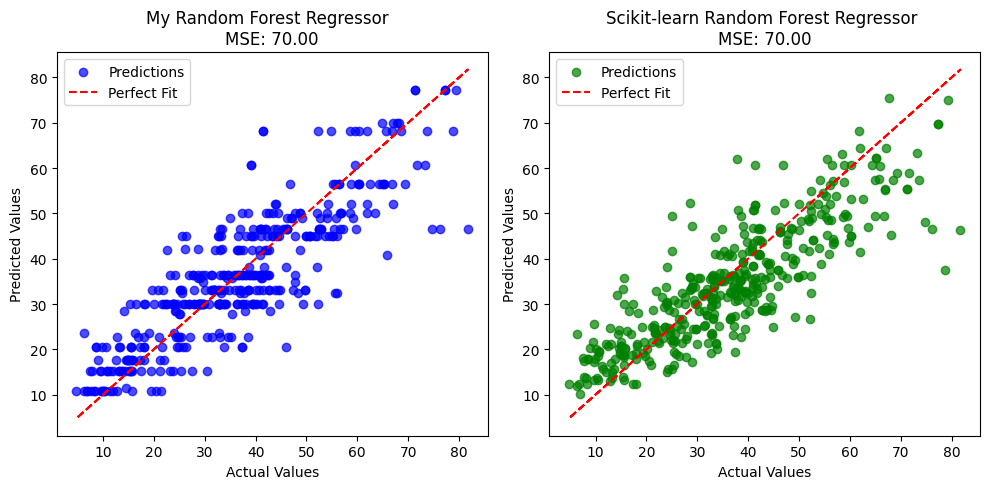

In [ ]:
# Create a mean_absolute_error measurement to compare results
my_rf_mean_absolute_error = mean_absolute_error(test_values, my_rf_predictions)
sklearn_rf_mean_absolute_error = mean_absolute_error(test_values, sklearn_rf_predictions)


# Evaluate MyRandomForestRegressor using Mean Squared Error
my_rf_mean_squared_error = mean_squared_error(test_values, my_rf_predictions)
print("My Random Forest Regressor Mean Squared Error:", my_rf_mean_squared_error)
print("My Random Forest Regressor Mean Absolute Error:", my_rf_mean_absolute_error)


# Evaluate scikit-learn RandomForestRegressor using Mean Squared Error
sklearn_rf_mean_squared_error = mean_squared_error(test_values, sklearn_rf_predictions)
print("\nScikit-learn Random Forest Regressor Mean Squared Error:", sklearn_rf_mean_squared_error)
print("Scikit-learn Random Forest Regressor Mean Absolute Error:", sklearn_rf_mean_absolute_error)

# Compare the results
print("\nDifference in Mean Squared Error:", abs(my_rf_mean_squared_error - sklearn_rf_mean_squared_error))



# Scatter plot for the My Random Forest Regressor
plt.figure(figsize=(10, 5))  # Set figure size

# Subplot for the My Random Forest Regressor
plt.subplot(1, 2, 1)  # Create the first subplot in a 1x2 grid
plt.scatter(test_values, my_dt_predictions, alpha=0.7, label="Predictions", color="blue")  # Plot predictions
plt.plot(test_values, test_values, color="red", linestyle="--", label="Perfect Fit")  # Add diagonal reference line
plt.title("My Random Forest Regressor  \nMSE: {:.2f}".format(sklearn_mse))  # Add title
plt.xlabel("Actual Values")  # Label for the x-axis
plt.ylabel("Predicted Values")  # Label for the y-axis
plt.legend()  # Add legend

# Subplot for the scikit-learn Random Forest Regressor
plt.subplot(1, 2, 2)  # Create the second subplot in a 1x2 grid
plt.scatter(test_values, sklearn_predictions, alpha=0.7, label="Predictions", color="green")  # Plot predictions
plt.plot(test_values, test_values, color="red", linestyle="--", label="Perfect Fit")  # Add diagonal reference line
plt.title("Scikit-learn Random Forest Regressor \nMSE: {:.2f}".format(sklearn_mse))  # Add title # Add title
plt.xlabel("Actual Values")  # Label for the x-axis
plt.ylabel("Predicted Values")  # Label for the y-axis
plt.legend()  # Add legend

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()  # Display the plot


### **Linear Regressor Implementation For Concrete Dataset**

In [ ]:
# Standardise the features to have a mean of 0 and standard deviation of 1
scaler = StandardScaler()
scaler.fit(train_examples)  # Fit the scaler to the training features
train_examples = scaler.transform(train_examples)  # Scale training features
test_examples = scaler.transform(test_examples)  # Scale testing features

# Instantiate and train the My Linear Regressor
my_linr_regressor = MyLinearRegressor()
my_linr_regressor.fit(train_examples, train_values)  # Train the model on the training dataset
# Generate predictions on the test dataset
my_linr_predictions = my_linr_regressor.predict(test_examples)

# Evaluate the my Linear Regressor
my_mse = mean_squared_error(test_values, my_linr_predictions)  # Mean Squared Error
my_rmse = np.sqrt(my_mse)  # Root Mean Squared Error
print("\nMy Linear Regressor Evaluation:")
print("Mean Squared Error:", my_mse)  # Print Mean Squared Error
print("Root Mean Squared Error:", my_rmse)  # Print Root Mean Squared Error

# scikit-learn
# Instantiate and train scikit-learn LinearRegression
sklearn_linr_regressor = LinearRegression()
sklearn_linr_regressor.fit(train_examples, train_values)  # Fit the model to the training data
# Generate predictions on the test dataset using scikit-learn's LinearRegression
sklearn_linr_predictions = sklearn_linr_regressor.predict(test_examples)

# Evaluate the scikit-learn LinearRegression
sklearn_mse = mean_squared_error(test_values, sklearn_linr_predictions)  # Mean Squared Error for sklearn
sklearn_rmse = np.sqrt(sklearn_mse)  # Root Mean Squared Error for sklearn
print("\nScikit-learn Linear Regressor Evaluation:")
print("Mean Squared Error:", sklearn_mse)  # Print Mean Squared Error for sklearn
print("Root Mean Squared Error:", sklearn_rmse)  # Print Root Mean Squared Error for sklearn



My Linear Regressor Evaluation:
Mean Squared Error: 104.36357739377692
Root Mean Squared Error: 10.215849323173131

Scikit-learn Linear Regressor Evaluation:
Mean Squared Error: 104.36357739377694
Root Mean Squared Error: 10.215849323173131


#### **EVALUATION: Linear Regressor Implementation For Concrete Dataset**


My Linear Regressor Mean Squared Error = 104.3636, R² = 0.6078

Scikit-learn LinearRegression Mean Squared Error = 104.3636, R² = 0.6078

My Linear Regressor Model vs scikit-learn LinearRegression Model



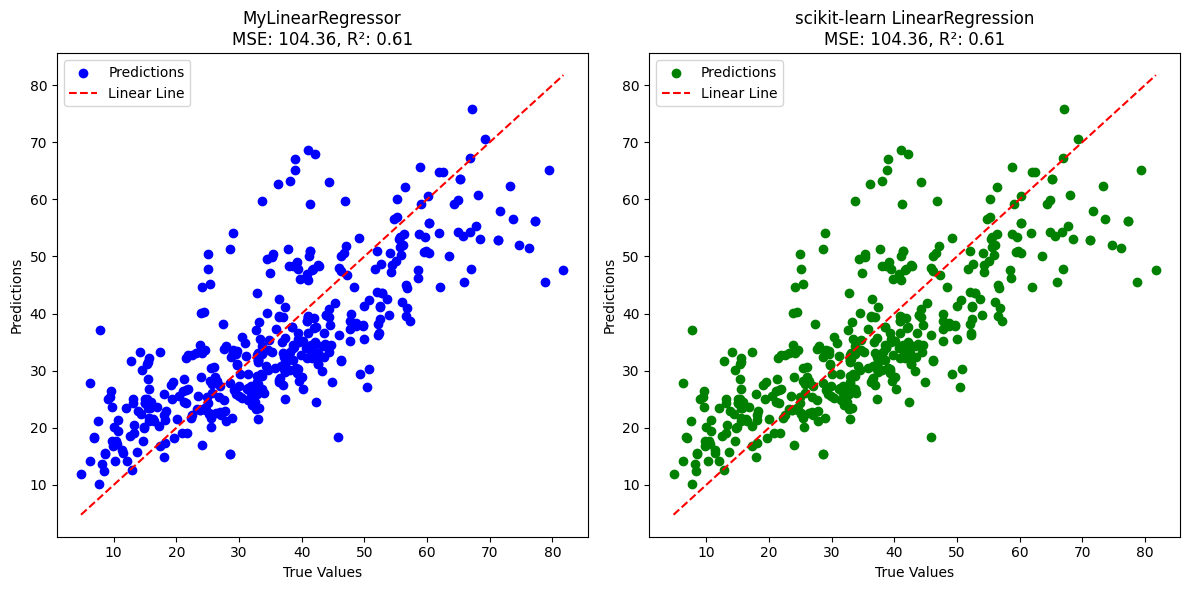

In [ ]:
# My Linear Regressor Model Evaluation
my_linr_mean_squared_error = mean_squared_error(test_values, my_linr_predictions)  # calculate the mse
my_r2 = r2_score(test_values, my_linr_predictions)  # calculate R²
print(f"\nMy Linear Regressor Mean Squared Error = {my_linr_mean_squared_error:.4f}, R² = {my_r2:.4f}")

# scikit-learn LinearRegression Model Evaluation
sklearn_mse = mean_squared_error(test_values, sklearn_linr_predictions)  # calculate the mse
sklearn_r2 = r2_score(test_values, sklearn_linr_predictions)  # calculate R²
print(f"\nScikit-learn LinearRegression Mean Squared Error = {sklearn_mse:.4f}, R² = {sklearn_r2:.4f}")

# Comparison of My Linear Regressor Model vs scikit-learn LinearRegression Model
print("\nMy Linear Regressor Model vs scikit-learn LinearRegression Model\n")
plt.figure(figsize=(12, 6))

# MyLinearRegressor predictions
plt.subplot(1, 2, 1)  # First subplot
plt.scatter(test_values, my_linr_predictions, color='blue', label='Predictions')
plt.plot([min(test_values), max(test_values)], [min(test_values), max(test_values)], 'r--', label='Linear Line')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title(f'MyLinearRegressor\nMSE: {my_linr_mean_squared_error:.2f}, R²: {my_r2:.2f}')
plt.legend()

# scikit-learn LinearRegression predictions
plt.subplot(1, 2, 2)  # Second subplot
plt.scatter(test_values, sklearn_linr_predictions, color='green', label='Predictions')
plt.plot([min(test_values), max(test_values)], [min(test_values), max(test_values)], 'r--', label='Linear Line')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title(f'scikit-learn LinearRegression\nMSE: {sklearn_mse:.2f}, R²: {sklearn_r2:.2f}')
plt.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


### **Linear Regressor (Stochastic Gradient Descent)**

In [ ]:
print("\n My SGD Regressor Implementation\n")
# Create a linear regression model object (using gradient descent):
my_logr_regressor = MyGDLinearRegressor(learning_rate=0.168, n_iterations=30)
# Fit the model to our training data
my_logr_regressor.fit(train_examples, train_values)
# Use the model to generate predictions for our testing examples
my_logr_predictions = my_logr_regressor.predict(test_examples)

# Find the mean squared error (MSE) between the model's predictions and the testing values
mse = ((my_logr_predictions - test_values) ** 2).mean()
# Display the MSE as a single quantitative measure of overall performance
print("Mean square error (MSE):", mse)
# Let's also see the square root of the MSE, which is easier for us to interpret
print("Root MSE: ", np.sqrt(mse))


 My SGD Regressor Implementation

-- Epoch 0
Norm: 2.27, NNZs: 8, Bias: 5.967102, T: 0, Avg. loss: 1548.630644
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 4.11, NNZs: 8, Bias: 10.931730, T: 618, Avg. loss: 1104.711295
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 5.60, NNZs: 8, Bias: 15.062301, T: 1236, Avg. loss: 799.608672
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 6.80, NNZs: 8, Bias: 18.498937, T: 1854, Avg. loss: 589.608897
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 7.79, NNZs: 8, Bias: 21.358217, T: 2472, Avg. loss: 444.860568
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 8.60, NNZs: 8, Bias: 23.737138, T: 3090, Avg. loss: 344.942579
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 9.27, NNZs: 8, Bias: 25.716401, T: 3708, Avg. loss: 275.863274
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 9.82, NNZs: 8, Bias: 27.363147, T: 4326, Avg. loss: 228.022822
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 10.28, NNZs: 8, Bias: 28.733240

#### **EVALUATION: Linear Regressor (Stochastic Gradient Descent)**

In [ ]:

print("\n The scikit-learn SGD Regressor Implementation\n")
# Create a linear regression model object (using gradient descent):
my_logr_regressor = SGDRegressor(verbose=1, n_iter_no_change=15)
# Fit the model to our training data
my_logr_regressor.fit(train_examples, train_values)
# Use the model to generate predictions for our testing examples
my_logr_predictions = my_logr_regressor.predict(test_examples)

# Find the mean squared error (MSE) between the model's predictions and the testing values
mse = ((my_logr_predictions - test_values) ** 2).mean()
# Display the MSE as a single quantitative measure of overall performance
print("Mean square error (MSE):", mse)
# Let's also see the square root of the MSE, which is easier for us to interpret
print("Root MSE: ", np.sqrt(mse))


 The scikit-learn SGD Regressor Implementation

-- Epoch 1
Norm: 10.19, NNZs: 8, Bias: 28.746620, T: 618, Avg. loss: 229.332377
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 11.75, NNZs: 8, Bias: 33.133050, T: 1236, Avg. loss: 70.929174
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 12.43, NNZs: 8, Bias: 34.621622, T: 1854, Avg. loss: 60.778646
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 12.94, NNZs: 8, Bias: 35.131942, T: 2472, Avg. loss: 58.950083
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 13.30, NNZs: 8, Bias: 35.267472, T: 3090, Avg. loss: 58.201365
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 13.50, NNZs: 8, Bias: 35.356882, T: 3708, Avg. loss: 57.809574
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 13.73, NNZs: 8, Bias: 35.416817, T: 4326, Avg. loss: 57.564576
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 13.94, NNZs: 8, Bias: 35.472778, T: 4944, Avg. loss: 57.313491
Total training time: 0.00 seconds.
-- Epoch 9
Norm: 14.17, NNZs: 8

### **Logistic Regression Implementation For Concrete Regression Dataset**

In [ ]:
# Calculate the mean of the training values to use as a threshold for binary use
threshold = train_values.mean()
# Convert train_values to binary: 1 if value > threshold, otherwise 0
train_values = (train_values > threshold).astype(int)
# Convert test_values to binary using the same threshold
test_values = (test_values > threshold).astype(int)


# Initialise the scaler to standardize features
scaler = StandardScaler()
# Fit the scaler to train_examples (calculate mean and std) and transform the data
train_examples = scaler.fit_transform(train_examples)
# Transform the test_examples using the same mean and std from train_examples
test_examples = scaler.transform(test_examples)


# my logistic regression model
# Set the learning rate to 0.01 and the number of iterations to 500
my_logr_regressor = MyGDLogisticRegressor(learning_rate=0.01, n_iterations=500)
# Train the logistic regression model using the standardized training data and binary labels
my_logr_regressor.fit(train_examples, train_values)
# Generate predictions
my_logr_predictions = my_logr_regressor.predict(test_examples)



# scikit-learn's Logistic Regression
sklearn_logr = LogisticRegression(max_iter=500)  # Ensure high enough iterations
sklearn_logr.fit(train_examples, train_values)
# Generate predictions
sklearn_predictions = sklearn_logr.predict(test_examples)

#### **EVALUATION: Logistic Regressor Implementation For Concrete Regression Dataset**

In [ ]:
# Compare accuracy
my_accuracy = np.sum(my_logr_predictions == test_values) / len(test_values)
sklearn_accuracy = accuracy_score(test_values, sklearn_predictions)
print(f"My Model Accuracy: {my_accuracy:.2f}")
print(f"Scikit-Learn Model Accuracy: {sklearn_accuracy:.2f}")

# Compare other metrics
print("\nClassification Report (My Model):")
print(classification_report(test_values, my_logr_predictions))
print("\nClassification Report (Scikit-Learn):")
print(classification_report(test_values, sklearn_predictions))

# Confusion Matrix
print("\nConfusion Matrix (My Model):")
print(confusion_matrix(test_values, my_logr_predictions))
print("\nConfusion Matrix (Scikit-Learn):")
print(confusion_matrix(test_values, sklearn_predictions))

My Model Accuracy: 0.81
Scikit-Learn Model Accuracy: 0.83

Classification Report (My Model):
              precision    recall  f1-score   support

           0       0.75      0.93      0.83       203
           1       0.91      0.70      0.79       209

    accuracy                           0.81       412
   macro avg       0.83      0.81      0.81       412
weighted avg       0.83      0.81      0.81       412


Classification Report (Scikit-Learn):
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       203
           1       0.90      0.76      0.82       209

    accuracy                           0.83       412
   macro avg       0.84      0.83      0.83       412
weighted avg       0.84      0.83      0.83       412


Confusion Matrix (My Model):
[[188  15]
 [ 62 147]]

Confusion Matrix (Scikit-Learn):
[[185  18]
 [ 51 158]]


# Submission

Once you're ready to submit, you need to compress the whole of your 1CWK50-ML folder as a .zip file (no other compression formats), and upload it to Moodle. There are several ways to do this, but the instructions below offer a simple step-by-step guide:

*    **Make sure the output from all your code cells is showing (you can select 'Runtime' -> 'Run all' if you need to)**
*    Save your notebook (select 'File' -> 'Save')
*    Find your /1CWK50-ML/ folder via the Google Drive web interface ([https://drive.google.com/](https://https://drive.google.com/))
*    Right-click on the /1CWK50-ML/ folder, and select 'Download'. This will cause the folder to be compressed into a .zip file and then downloaded to your local machine.
*    Upload the resulting .zip file to the 1CWK50 submission point on Moodle.

**We recommend testing these steps, and asking any questions you might have, well before the final deadline.**